# Analysis of Model Training Results for All 22 Phoneme Pairs

This notebook analyzes the results from training hybrid CNN+MLP models for phoneme classification across all 22 phoneme pairs.

For each pair, we will:
1. Load predictions and metrics
2. Create confusion matrices
3. Visualize probability distributions for correct vs incorrect predictions
4. Analyze misclassified phonemes

In [17]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Project root
# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Define paths for all 22 phoneme pairs (using v4_3_enhanced for all pairs)
PAIRS_CONFIG = {
    'a-ɛ': {
        'name': 'a-ɛ',
        'class_0': 'a',
        'class_1': 'ɛ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'a-ɛ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'a-ɛ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'aː-a': {
        'name': 'aː-a',
        'class_0': 'aː',
        'class_1': 'a',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'aː-a_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'aː-a_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'aɪ̯-aː': {
        'name': 'aɪ̯-aː',
        'class_0': 'aɪ̯',
        'class_1': 'aː',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'aɪ̯-aː_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'aɪ̯-aː_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'aʊ̯-aː': {
        'name': 'aʊ̯-aː',
        'class_0': 'aʊ̯',
        'class_1': 'aː',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'aʊ̯-aː_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'aʊ̯-aː_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'b-p': {
        'name': 'b-p (Bilabial Plosives)',
        'class_0': 'b',
        'class_1': 'p',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'd-t': {
        'name': 'd-t (Alveolar Plosives)',
        'class_0': 'd',
        'class_1': 't',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'eː-ɛ': {
        'name': 'eː-ɛ',
        'class_0': 'eː',
        'class_1': 'ɛ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'eː-ɛ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'eː-ɛ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'g-k': {
        'name': 'g-k (Velar Plosives)',
        'class_0': 'g',
        'class_1': 'k',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'iː-ɪ': {
        'name': 'iː-ɪ',
        'class_0': 'iː',
        'class_1': 'ɪ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'iː-ɪ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'iː-ɪ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'kʰ-g': {
        'name': 'kʰ-g',
        'class_0': 'kʰ',
        'class_1': 'ɡ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'kʰ-g_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'kʰ-g_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'oː-ɔ': {
        'name': 'oː-ɔ',
        'class_0': 'oː',
        'class_1': 'ɔ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'oː-ɔ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'oː-ɔ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    's-ʃ': {
        'name': 's-ʃ',
        'class_0': 's',
        'class_1': 'ʃ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 's-ʃ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 's-ʃ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'ts-s': {
        'name': 'ts-s',
        'class_0': 'ts',
        'class_1': 's',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'ts-s_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'ts-s_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'tʰ-d': {
        'name': 'tʰ-d',
        'class_0': 'tʰ',
        'class_1': 'd',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'tʰ-d_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'tʰ-d_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'uː-ʊ': {
        'name': 'uː-ʊ',
        'class_0': 'uː',
        'class_1': 'ʊ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'uː-ʊ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'uː-ʊ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'x-k': {
        'name': 'x-k',
        'class_0': 'x',
        'class_1': 'k',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'x-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'x-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'z-s': {
        'name': 'z-s',
        'class_0': 'z',
        'class_1': 's',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'z-s_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'z-s_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'ç-x': {
        'name': 'ç-x',
        'class_0': 'ç',
        'class_1': 'x',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'ç-x_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'ç-x_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'ç-ʃ': {
        'name': 'ç-ʃ',
        'class_0': 'ç',
        'class_1': 'ʃ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'ç-ʃ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'ç-ʃ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'ŋ-n': {
        'name': 'ŋ-n',
        'class_0': 'ŋ',
        'class_1': 'n',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'ŋ-n_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'ŋ-n_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'ə-ɛ': {
        'name': 'ə-ɛ',
        'class_0': 'ə',
        'class_1': 'ɛ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'ə-ɛ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'ə-ɛ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
    'ʁ-ɐ': {
        'name': 'ʁ-ɐ',
        'class_0': 'ʁ',
        'class_1': 'ɐ',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'ʁ-ɐ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'ʁ-ɐ_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_3_enhanced' / 'test_metrics.json',
    },
}

print("Configuration loaded successfully!")
print(f"\nAnalyzing {len(PAIRS_CONFIG)} phoneme pairs:")
for pair_name, config in PAIRS_CONFIG.items():
    print(f"  - {config['name']}")

Configuration loaded successfully!

Analyzing 22 phoneme pairs:
  - a-ɛ
  - aː-a
  - aɪ̯-aː
  - aʊ̯-aː
  - b-p (Bilabial Plosives)
  - d-t (Alveolar Plosives)
  - eː-ɛ
  - g-k (Velar Plosives)
  - iː-ɪ
  - kʰ-g
  - oː-ɔ
  - s-ʃ
  - ts-s
  - tʰ-d
  - uː-ʊ
  - x-k
  - z-s
  - ç-x
  - ç-ʃ
  - ŋ-n
  - ə-ɛ
  - ʁ-ɐ


## Part 1: Analysis Function

We'll create a function to analyze each phoneme pair, then apply it to all 22 pairs.

In [18]:
def analyze_phoneme_pair(pair_key, config, show_plots=True):
    """
    Analyze a single phoneme pair.
    
    Args:
        pair_key: Key for the pair (e.g., 'b-p')
        config: Configuration dictionary for the pair
        show_plots: Whether to display plots
    """
    print(f"\n{'='*70}")
    print(f"Analyzing: {config['name']}")
    print(f"{'='*70}")
    
    try:
        # Load predictions
        predictions_df = pd.read_csv(config['predictions_path'])
        print(f"\nLoaded {len(predictions_df)} predictions")
        print(f"Correct: {predictions_df['is_correct'].sum()}, Incorrect: {(~predictions_df['is_correct'].astype(bool)).sum()}")
        
        # Load metrics
        with open(config['metrics_path'], 'r') as f:
            metrics = json.load(f)
        
        print(f"\nModel Performance:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1-score: {metrics['f1']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
        
        # Confusion Matrix
        y_true = predictions_df['true_class_encoded'].values
        y_pred = predictions_df['predicted_class_encoded'].values
        cm = confusion_matrix(y_true, y_pred)
        
        if show_plots:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Confusion Matrix (absolute values)
            ax1 = axes[0]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                        xticklabels=[config['class_0'], config['class_1']],
                        yticklabels=[config['class_0'], config['class_1']])
            ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
            ax1.set_ylabel('True', fontsize=12, fontweight='bold')
            ax1.set_title(f'Confusion Matrix (Absolute): {config["name"]}', fontsize=14, fontweight='bold')
            
            # Confusion Matrix (percentage)
            ax2 = axes[1]
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                        xticklabels=[config['class_0'], config['class_1']],
                        yticklabels=[config['class_0'], config['class_1']])
            ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
            ax2.set_ylabel('True', fontsize=12, fontweight='bold')
            ax2.set_title(f'Confusion Matrix (Percentage): {config["name"]}', fontsize=14, fontweight='bold')
            
            plt.suptitle(f'Analysis: {config["name"]}', fontsize=16, fontweight='bold', y=1.0)
            plt.tight_layout()
            plt.show()
        
        # Extract probabilities for later use
        correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
        incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
        
        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, 
                                  target_names=[config['class_0'], config['class_1']],
                                  digits=4))
        
        # Misclassification Analysis
        misclassified = predictions_df[predictions_df['is_correct'] == 0].copy()
        print(f"\nTotal misclassifications: {len(misclassified)}")
        print(f"\nMisclassifications by true class:")
        for true_class in [config['class_0'], config['class_1']]:
            count = len(misclassified[misclassified['true_class'] == true_class])
            total = len(predictions_df[predictions_df['true_class'] == true_class])
            pct = (count / total) * 100 if total > 0 else 0
            print(f"  {true_class}: {count}/{total} ({pct:.2f}%)")
        
        # Probability Statistics
        if len(misclassified) > 0:
            print(f"\nProbability Statistics:")
            print(f"Correct predictions:")
            print(f"  Mean: {correct_probs.mean():.4f}, Median: {np.median(correct_probs):.4f}, Std: {correct_probs.std():.4f}")
            print(f"Incorrect predictions:")
            print(f"  Mean: {incorrect_probs.mean():.4f}, Median: {np.median(incorrect_probs):.4f}, Std: {incorrect_probs.std():.4f}")
        
        # Detailed misclassification analysis
        print(f"\n{'='*70}")
        print(f"DETAILED MISCLASSIFICATION ANALYSIS: {config['name']}")
        print(f"{'='*70}")
        
        if len(misclassified) > 0:
            print(f"\nMisclassified phonemes with highest confidence (most confident errors):")
            top_errors = misclassified.nlargest(10, 'max_prob')[['phoneme_id', 'true_class', 'predicted_class', 'max_prob']]
            print(top_errors.to_string(index=False))
            
            print(f"\nMisclassified phonemes with lowest confidence (uncertain errors):")
            low_errors = misclassified.nsmallest(10, 'max_prob')[['phoneme_id', 'true_class', 'predicted_class', 'max_prob']]
            print(low_errors.to_string(index=False))
            
            # Confusion matrix breakdown
            print(f"\nConfusion Matrix Breakdown:")
            print(f"  True {config['class_0']} predicted as {config['class_0']}: {cm[0, 0]}")
            print(f"  True {config['class_0']} predicted as {config['class_1']}: {cm[0, 1]}")
            print(f"  True {config['class_1']} predicted as {config['class_0']}: {cm[1, 0]}")
            print(f"  True {config['class_1']} predicted as {config['class_1']}: {cm[1, 1]}")
            
            # Detailed probability distribution visualization
            if show_plots:
                fig, axes = plt.subplots(2, 2, figsize=(14, 10))
                
                # Histogram of correct predictions
                ax1 = axes[0, 0]
                ax1.hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
                ax1.axvline(correct_probs.mean(), color='red', linestyle='--', linewidth=2, 
                           label=f'Mean: {correct_probs.mean():.3f}')
                ax1.set_xlabel('Predicted Probability', fontweight='bold')
                ax1.set_ylabel('Frequency', fontweight='bold')
                ax1.set_title('Correct Predictions - Probability Distribution', fontweight='bold')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Histogram of incorrect predictions
                ax2 = axes[0, 1]
                ax2.hist(incorrect_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
                ax2.axvline(incorrect_probs.mean(), color='blue', linestyle='--', linewidth=2, 
                           label=f'Mean: {incorrect_probs.mean():.3f}')
                ax2.set_xlabel('Predicted Probability', fontweight='bold')
                ax2.set_ylabel('Frequency', fontweight='bold')
                ax2.set_title('Incorrect Predictions - Probability Distribution', fontweight='bold')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                # Overlay comparison
                ax3 = axes[1, 0]
                ax3.hist(correct_probs, bins=30, alpha=0.6, color='green', label='Correct', edgecolor='black')
                ax3.hist(incorrect_probs, bins=30, alpha=0.6, color='red', label='Incorrect', edgecolor='black')
                ax3.set_xlabel('Predicted Probability', fontweight='bold')
                ax3.set_ylabel('Frequency', fontweight='bold')
                ax3.set_title('Probability Distribution Comparison', fontweight='bold')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                
                # Box plot comparison
                ax4 = axes[1, 1]
                bp = ax4.boxplot([correct_probs, incorrect_probs], labels=['Correct', 'Incorrect'], patch_artist=True)
                bp['boxes'][0].set_facecolor('lightgreen')
                bp['boxes'][1].set_facecolor('lightcoral')
                ax4.set_ylabel('Predicted Probability', fontweight='bold')
                ax4.set_title('Probability Distribution: Box Plot', fontweight='bold')
                ax4.grid(True, alpha=0.3, axis='y')
                
                plt.suptitle(f'Detailed Probability Analysis: {config["name"]}', 
                             fontsize=16, fontweight='bold', y=1.0)
                plt.tight_layout()
                plt.show()
        else:
            print("\nNo misclassifications found!")
        
        return {
            'pair_key': pair_key,
            'config': config,
            'predictions_df': predictions_df,
            'metrics': metrics,
            'cm': cm,
            'correct_probs': correct_probs,
            'incorrect_probs': incorrect_probs
        }
        
    except Exception as e:
        print(f"\nError analyzing {pair_key}: {e}")
        return None

## Part 2: Analyze All 22 Phoneme Pairs

We'll analyze each pair sequentially. You can modify the code to analyze specific pairs or skip certain ones.


Analyzing: a-ɛ

Loaded 14292 predictions
Correct: 13954, Incorrect: 338

Model Performance:
  Accuracy: 0.9764
  F1-score: 0.9764
  Precision: 0.9764
  Recall: 0.9764
  ROC-AUC: 0.9963


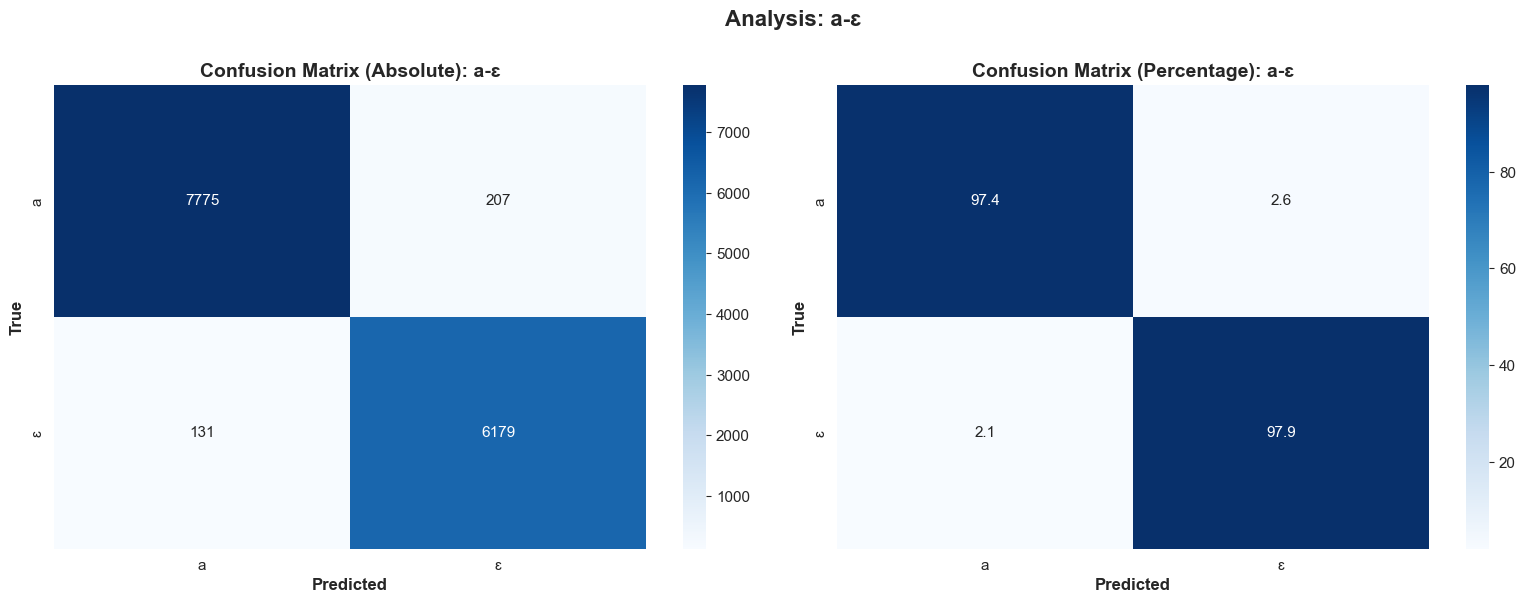


Classification Report:
              precision    recall  f1-score   support

           a     0.9834    0.9741    0.9787      7982
           ɛ     0.9676    0.9792    0.9734      6310

    accuracy                         0.9764     14292
   macro avg     0.9755    0.9767    0.9761     14292
weighted avg     0.9764    0.9764    0.9764     14292


Total misclassifications: 338

Misclassifications by true class:
  a: 207/7982 (2.59%)
  ɛ: 131/6310 (2.08%)

Probability Statistics:
Correct predictions:
  Mean: 0.8795, Median: 0.9030, Std: 0.0804
Incorrect predictions:
  Mean: 0.6578, Median: 0.6399, Std: 0.1115

DETAILED MISCLASSIFICATION ANALYSIS: a-ɛ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      59316          a               ɛ  0.932226
      57801          a               ɛ  0.918545
      22720          a               ɛ  0.907724
      16272          a               ɛ  0.901585
      49570          ɛ

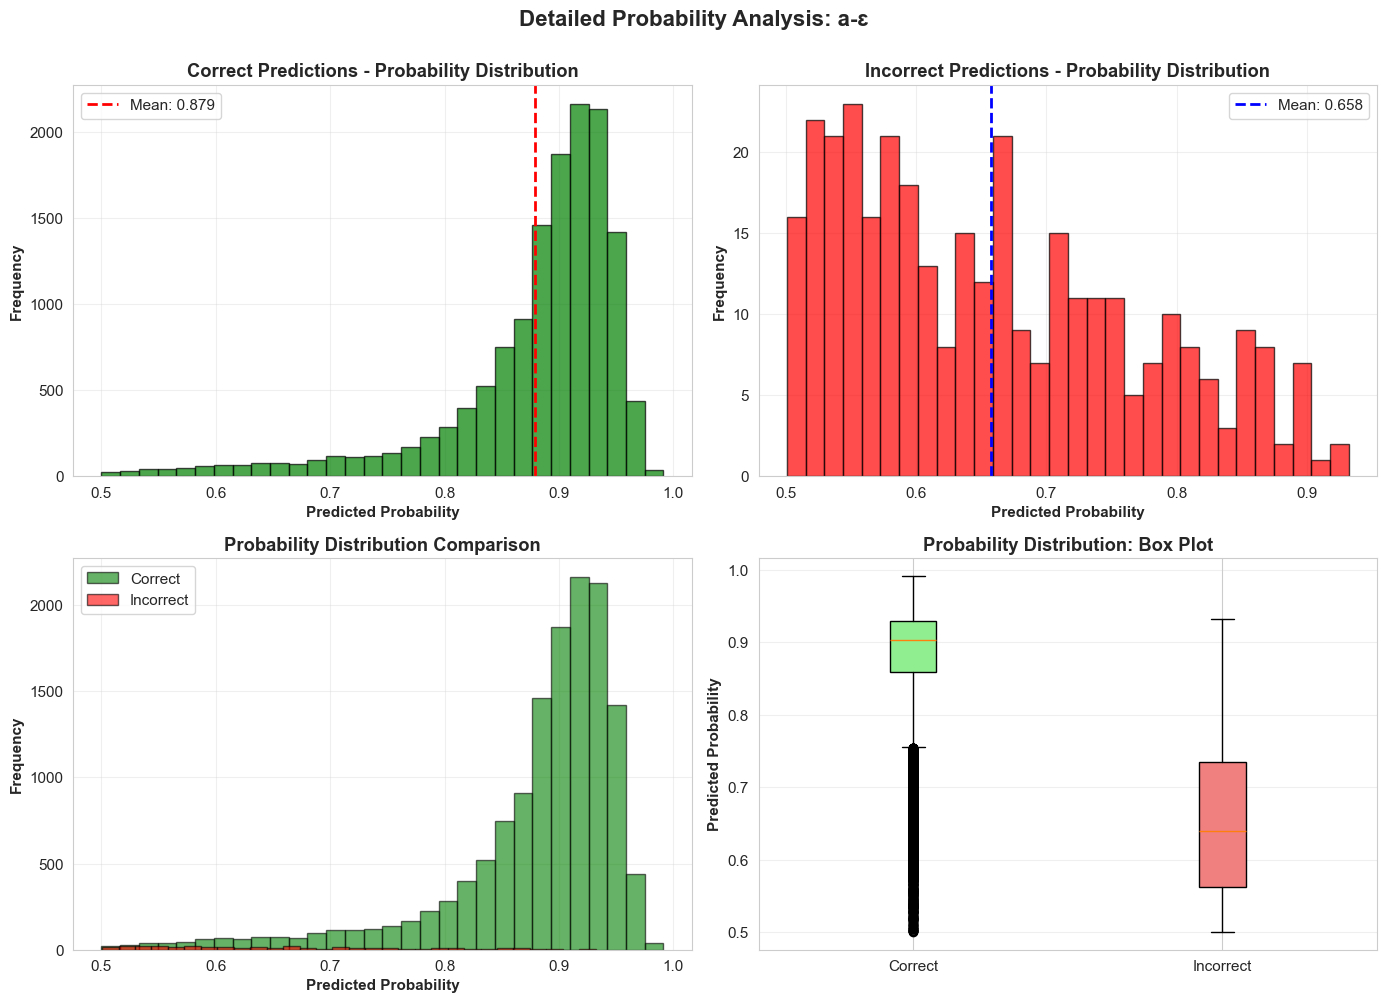




Analyzing: aː-a

Loaded 11856 predictions
Correct: 10017, Incorrect: 1839

Model Performance:
  Accuracy: 0.8449
  F1-score: 0.8484
  Precision: 0.8621
  Recall: 0.8449
  ROC-AUC: 0.9264


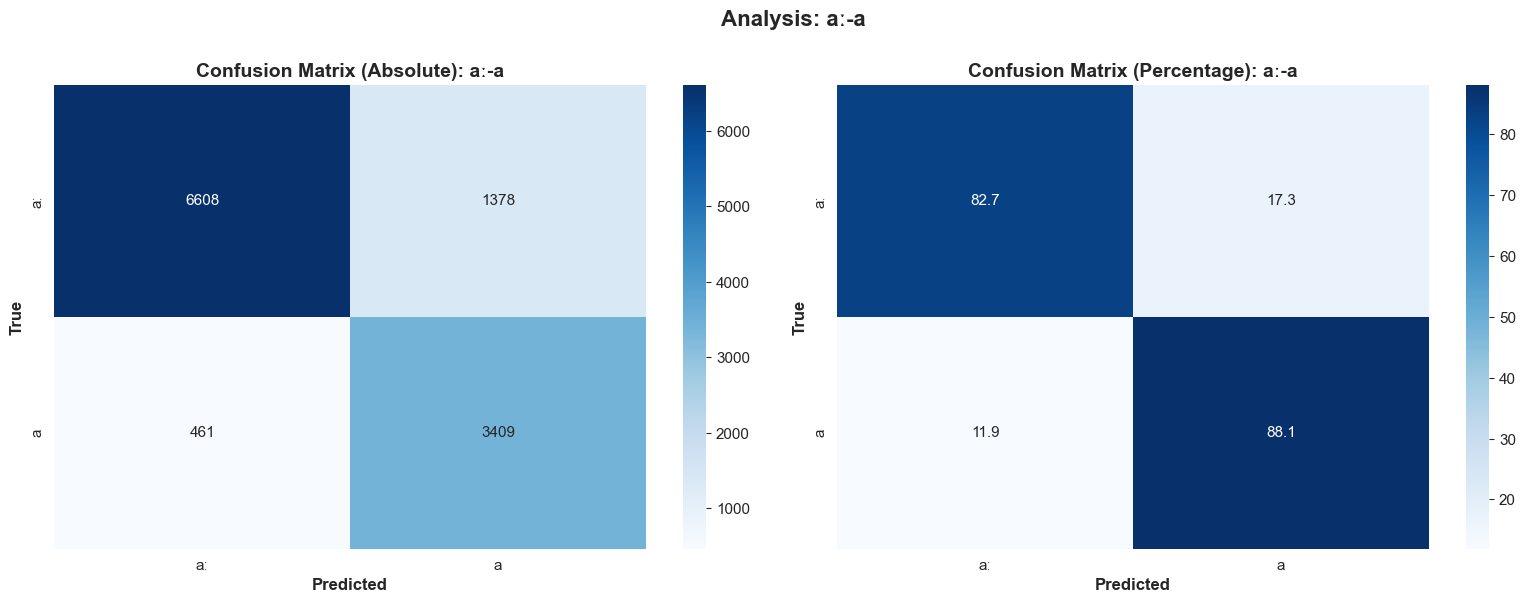


Classification Report:
              precision    recall  f1-score   support

          aː     0.9348    0.8274    0.8778      7986
           a     0.7121    0.8809    0.7876      3870

    accuracy                         0.8449     11856
   macro avg     0.8235    0.8542    0.8327     11856
weighted avg     0.8621    0.8449    0.8484     11856


Total misclassifications: 1839

Misclassifications by true class:
  aː: 461/3870 (11.91%)
  a: 1378/7986 (17.26%)

Probability Statistics:
Correct predictions:
  Mean: 0.7125, Median: 0.7265, Std: 0.0947
Incorrect predictions:
  Mean: 0.6174, Median: 0.5942, Std: 0.0889

DETAILED MISCLASSIFICATION ANALYSIS: aː-a

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      15699         aː               a  0.870681
      31214          a              aː  0.868522
      27774          a              aː  0.867857
      71538          a              aː  0.863929
      39545     

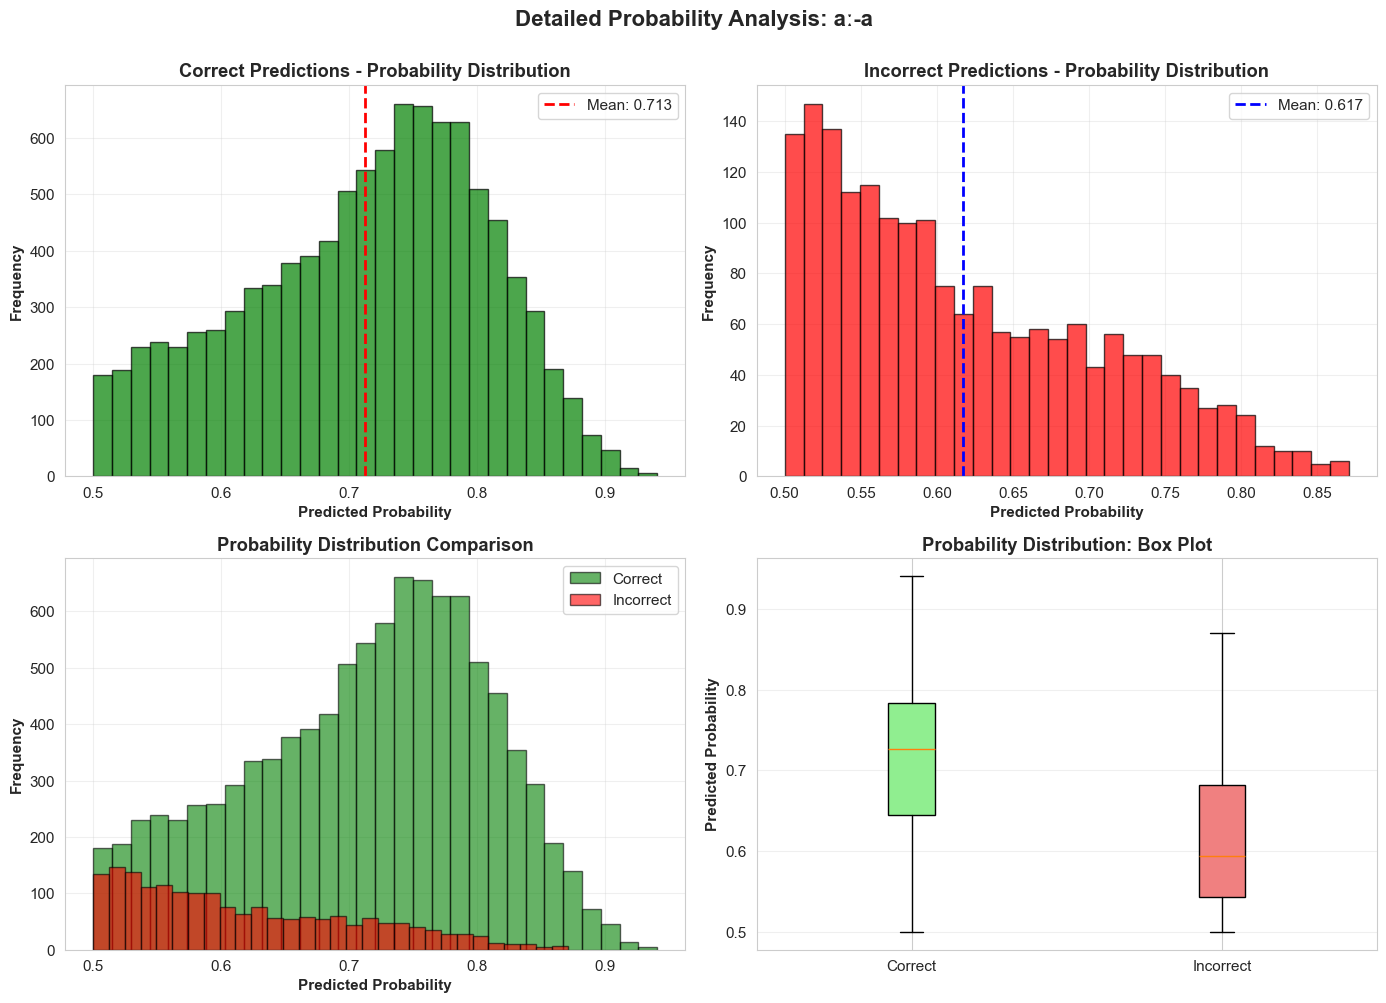




Analyzing: aɪ̯-aː

Loaded 8530 predictions
Correct: 7755, Incorrect: 775

Model Performance:
  Accuracy: 0.9091
  F1-score: 0.9093
  Precision: 0.9096
  Recall: 0.9091
  ROC-AUC: 0.9685


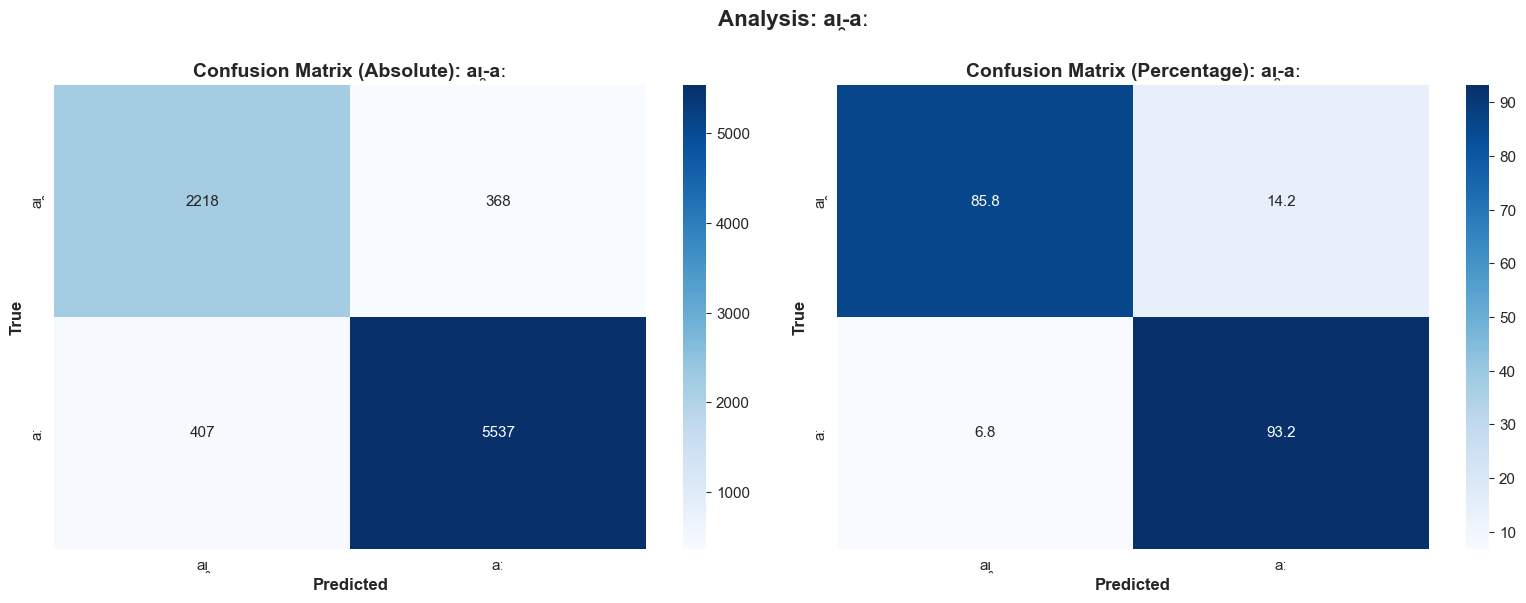


Classification Report:
              precision    recall  f1-score   support

         aɪ̯     0.8450    0.8577    0.8513      2586
          aː     0.9377    0.9315    0.9346      5944

    accuracy                         0.9091      8530
   macro avg     0.8913    0.8946    0.8929      8530
weighted avg     0.9096    0.9091    0.9093      8530


Total misclassifications: 775

Misclassifications by true class:
  aɪ̯: 368/2586 (14.23%)
  aː: 407/5944 (6.85%)

Probability Statistics:
Correct predictions:
  Mean: 0.8209, Median: 0.9232, Std: 0.1481
Incorrect predictions:
  Mean: 0.5958, Median: 0.5801, Std: 0.0785

DETAILED MISCLASSIFICATION ANALYSIS: aɪ̯-aː

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      39305        aɪ̯              aː  0.916791
      43408        aɪ̯              aː  0.914885
      31371        aɪ̯              aː  0.911858
      35069        aɪ̯              aː  0.908613
      36396    

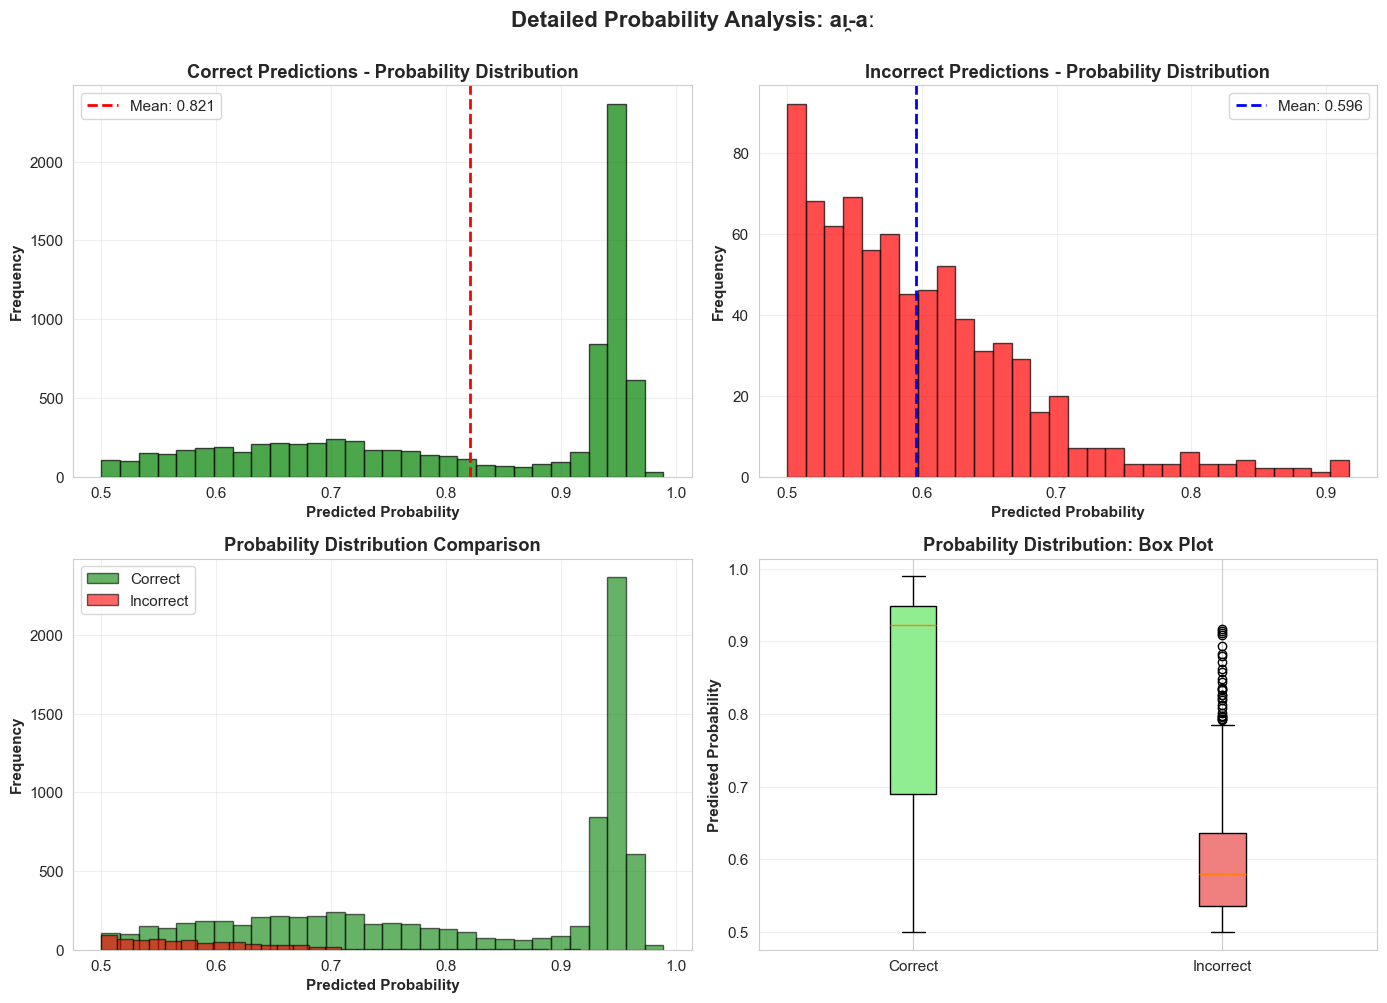




Analyzing: aʊ̯-aː

Loaded 5953 predictions
Correct: 5901, Incorrect: 52

Model Performance:
  Accuracy: 0.9913
  F1-score: 0.9913
  Precision: 0.9913
  Recall: 0.9913
  ROC-AUC: 0.9994


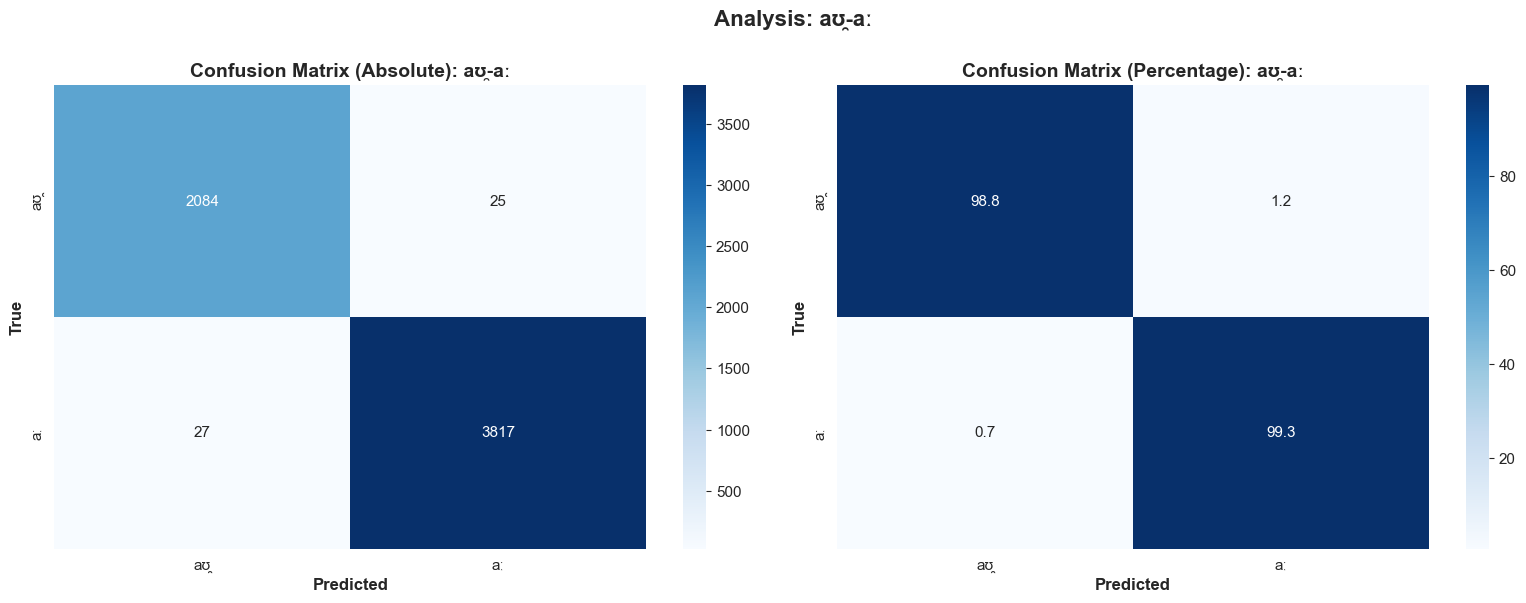


Classification Report:
              precision    recall  f1-score   support

         aʊ̯     0.9872    0.9881    0.9877      2109
          aː     0.9935    0.9930    0.9932      3844

    accuracy                         0.9913      5953
   macro avg     0.9904    0.9906    0.9905      5953
weighted avg     0.9913    0.9913    0.9913      5953


Total misclassifications: 52

Misclassifications by true class:
  aʊ̯: 0/0 (0.00%)
  aː: 27/3844 (0.70%)

Probability Statistics:
Correct predictions:
  Mean: 0.9268, Median: 0.9436, Std: 0.0613
Incorrect predictions:
  Mean: 0.6497, Median: 0.6299, Std: 0.1071

DETAILED MISCLASSIFICATION ANALYSIS: aʊ̯-aː

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      33744         aw              aː  0.944124
      17269         aw              aː  0.879788
      14583         aw              aː  0.862163
      10408         aw              aː  0.819495
       6614         aː 

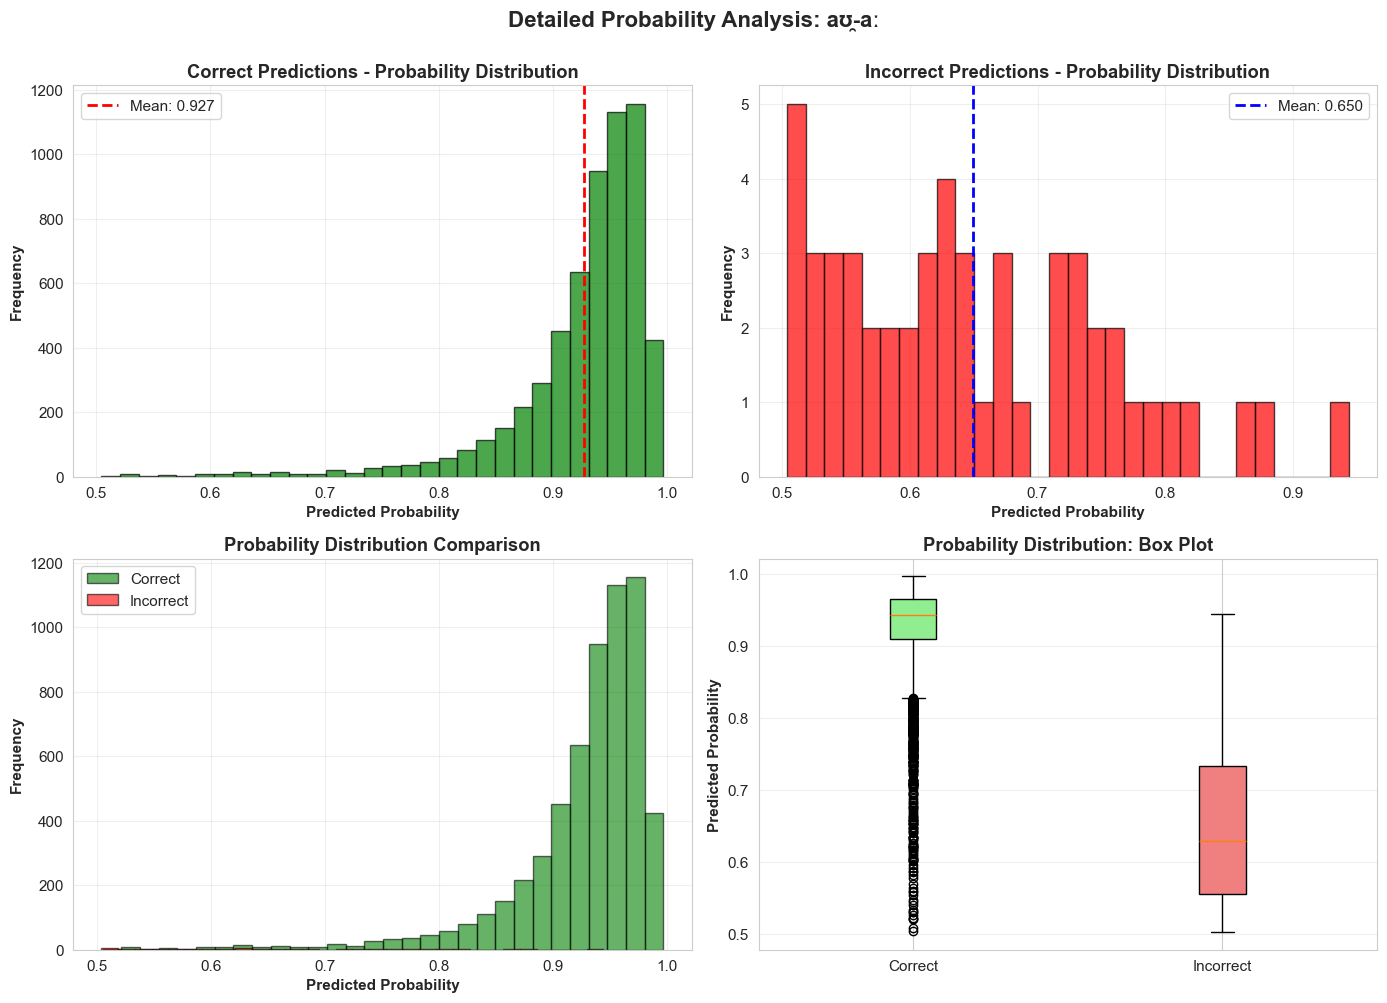




Analyzing: b-p (Bilabial Plosives)

Loaded 5536 predictions
Correct: 5303, Incorrect: 233

Model Performance:
  Accuracy: 0.9579
  F1-score: 0.9581
  Precision: 0.9584
  Recall: 0.9579
  ROC-AUC: 0.9882


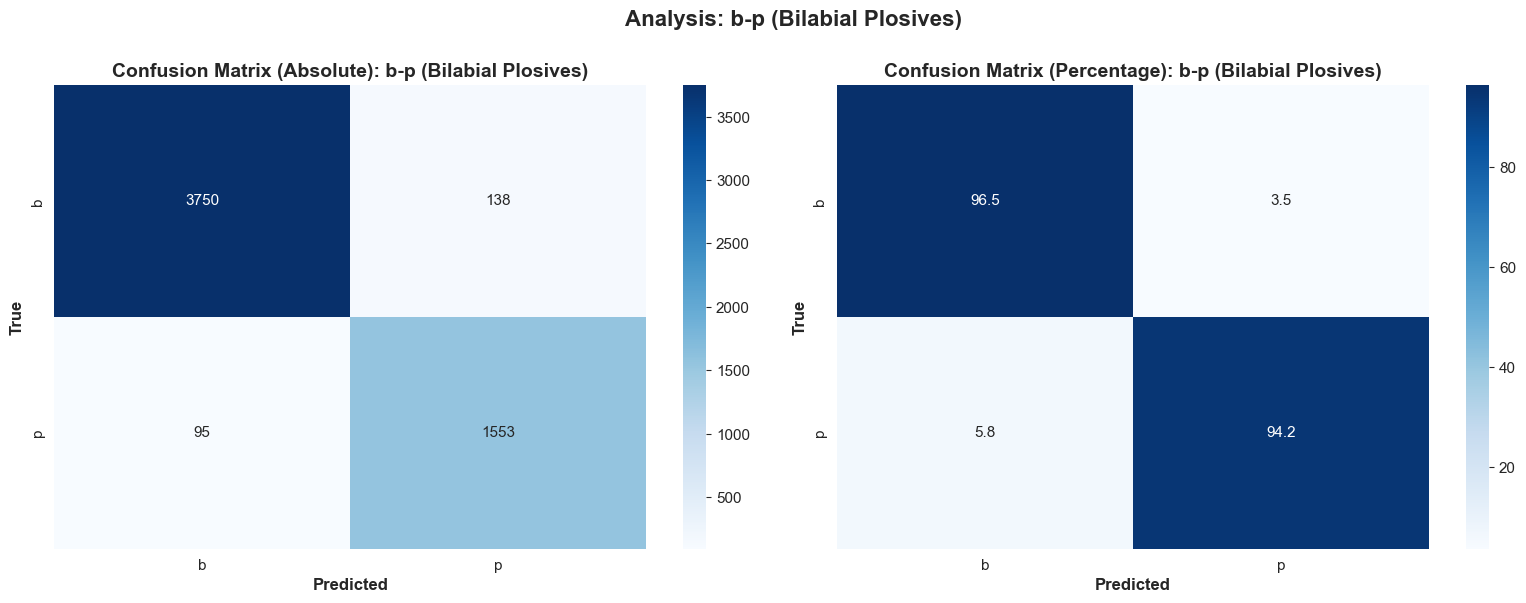


Classification Report:
              precision    recall  f1-score   support

           b     0.9753    0.9645    0.9699      3888
           p     0.9184    0.9424    0.9302      1648

    accuracy                         0.9579      5536
   macro avg     0.9468    0.9534    0.9500      5536
weighted avg     0.9584    0.9579    0.9581      5536


Total misclassifications: 233

Misclassifications by true class:
  b: 138/3888 (3.55%)
  p: 95/1648 (5.76%)

Probability Statistics:
Correct predictions:
  Mean: 0.9008, Median: 0.9275, Std: 0.0852
Incorrect predictions:
  Mean: 0.7035, Median: 0.6909, Std: 0.1369

DETAILED MISCLASSIFICATION ANALYSIS: b-p (Bilabial Plosives)

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      33353          p               b  0.979342
      15778          p               b  0.974081
      16403          b               p  0.964144
      28600          b               p  0.954463
   

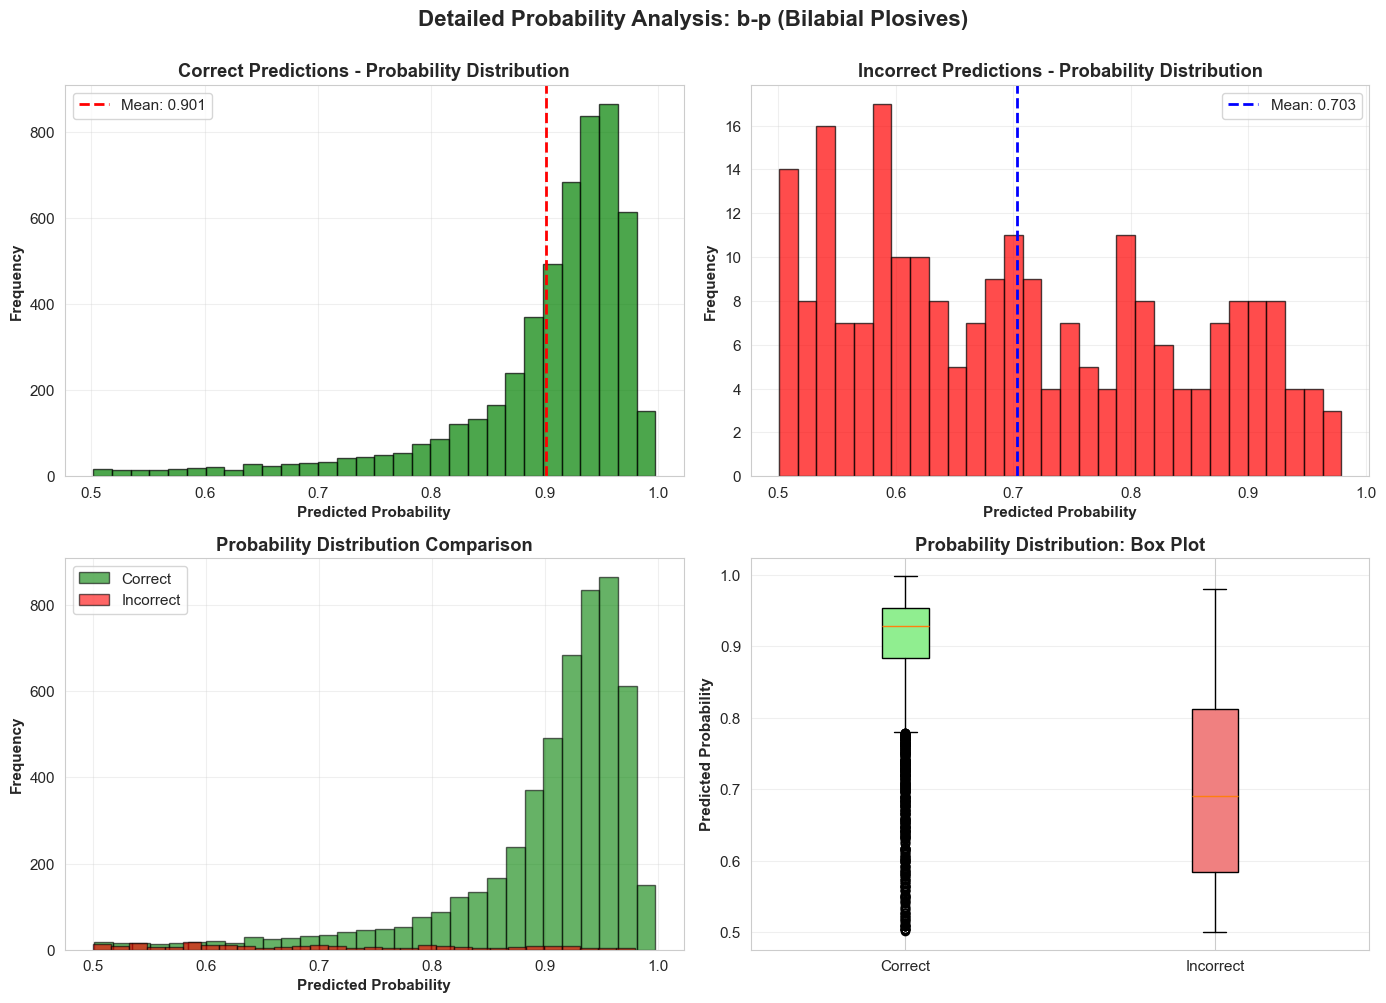




Analyzing: d-t (Alveolar Plosives)

Loaded 19949 predictions
Correct: 18836, Incorrect: 1113

Model Performance:
  Accuracy: 0.9442
  F1-score: 0.9443
  Precision: 0.9445
  Recall: 0.9442
  ROC-AUC: 0.9872


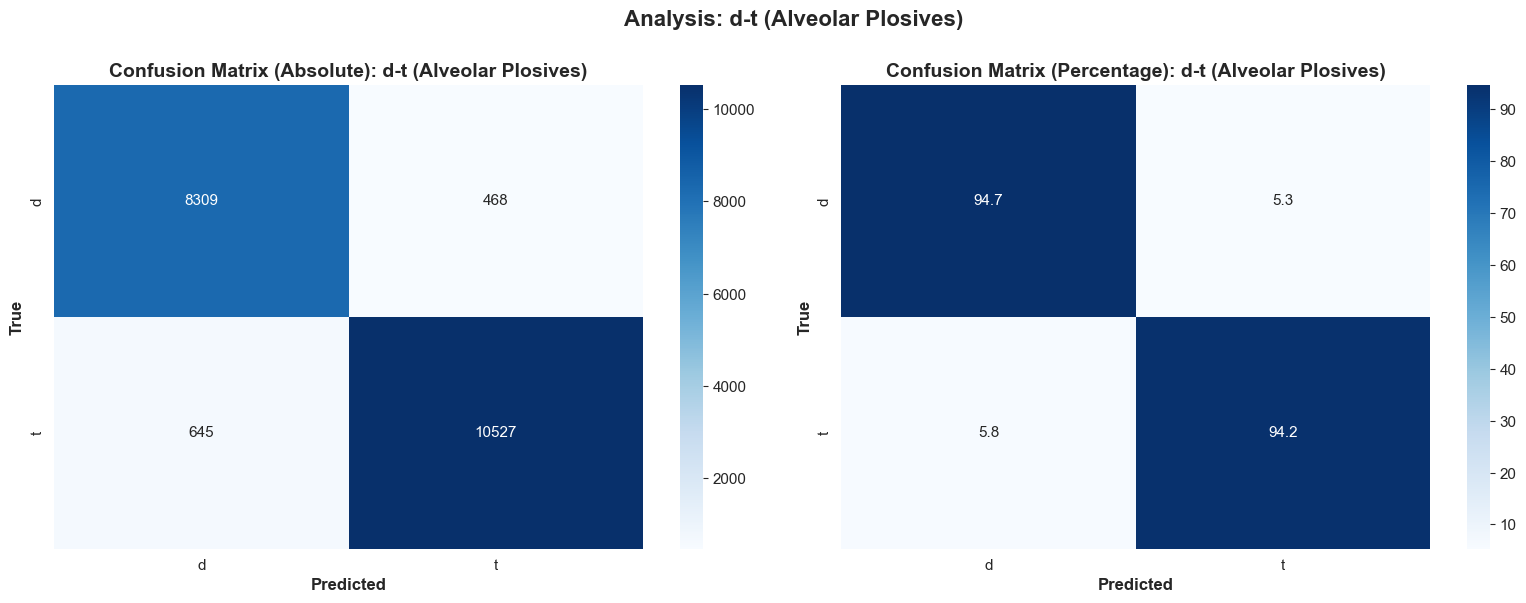


Classification Report:
              precision    recall  f1-score   support

           d     0.9280    0.9467    0.9372      8777
           t     0.9574    0.9423    0.9498     11172

    accuracy                         0.9442     19949
   macro avg     0.9427    0.9445    0.9435     19949
weighted avg     0.9445    0.9442    0.9443     19949


Total misclassifications: 1113

Misclassifications by true class:
  d: 468/8777 (5.33%)
  t: 645/11172 (5.77%)

Probability Statistics:
Correct predictions:
  Mean: 0.8499, Median: 0.8740, Std: 0.1019
Incorrect predictions:
  Mean: 0.6387, Median: 0.6165, Std: 0.1062

DETAILED MISCLASSIFICATION ANALYSIS: d-t (Alveolar Plosives)

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      87884          d               t  0.987784
      62300          d               t  0.963137
     126750          d               t  0.937092
      39718          d               t  0.925554


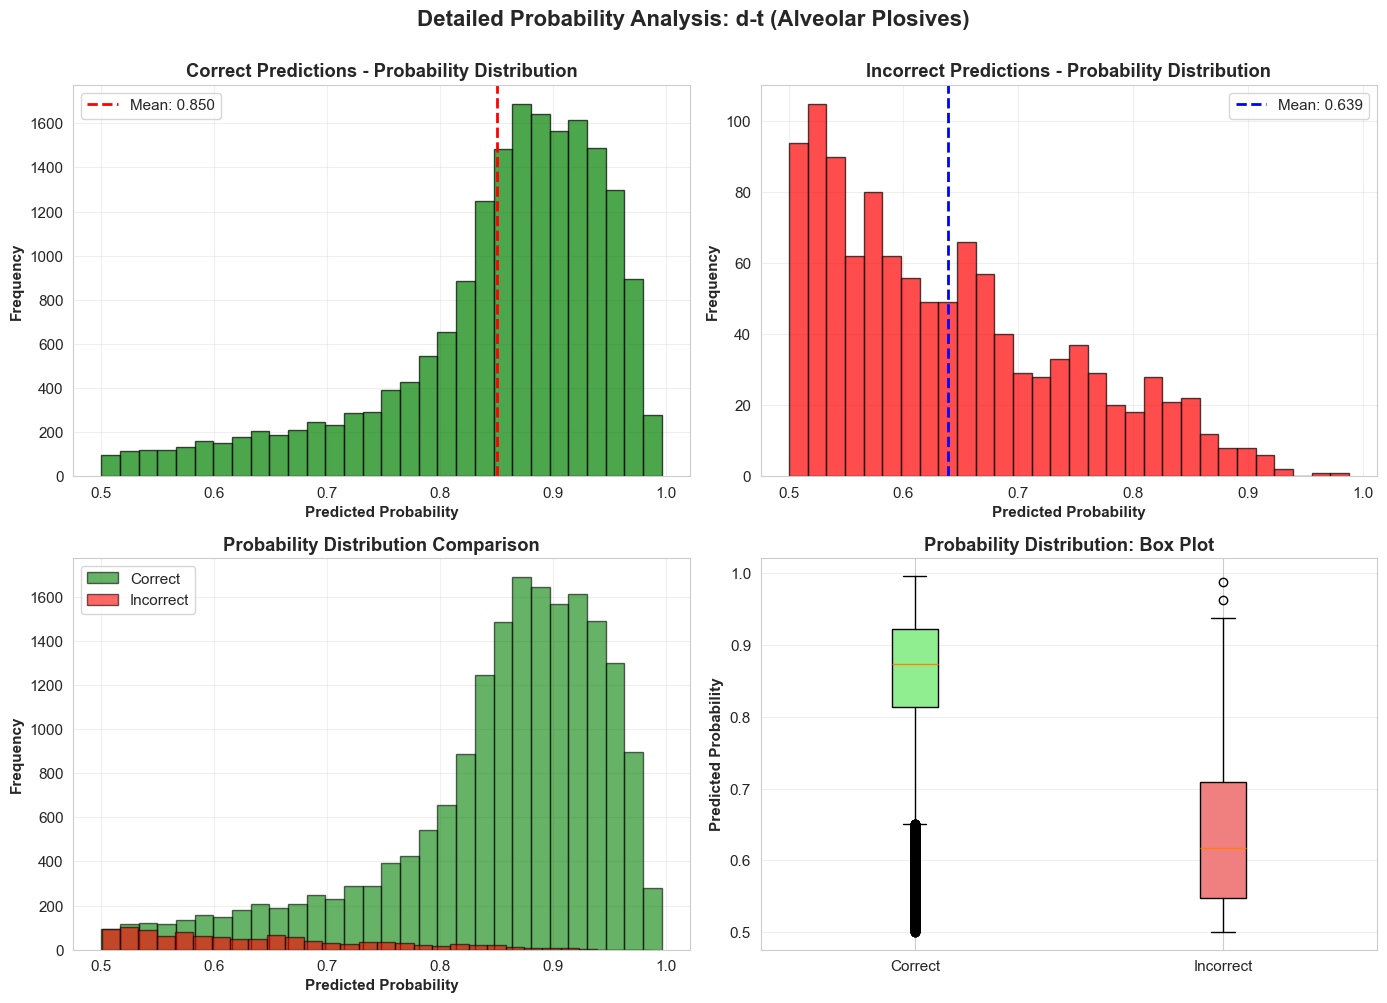




Analyzing: eː-ɛ

Loaded 8530 predictions
Correct: 7467, Incorrect: 1063

Model Performance:
  Accuracy: 0.8754
  F1-score: 0.8751
  Precision: 0.8752
  Recall: 0.8754
  ROC-AUC: 0.9450


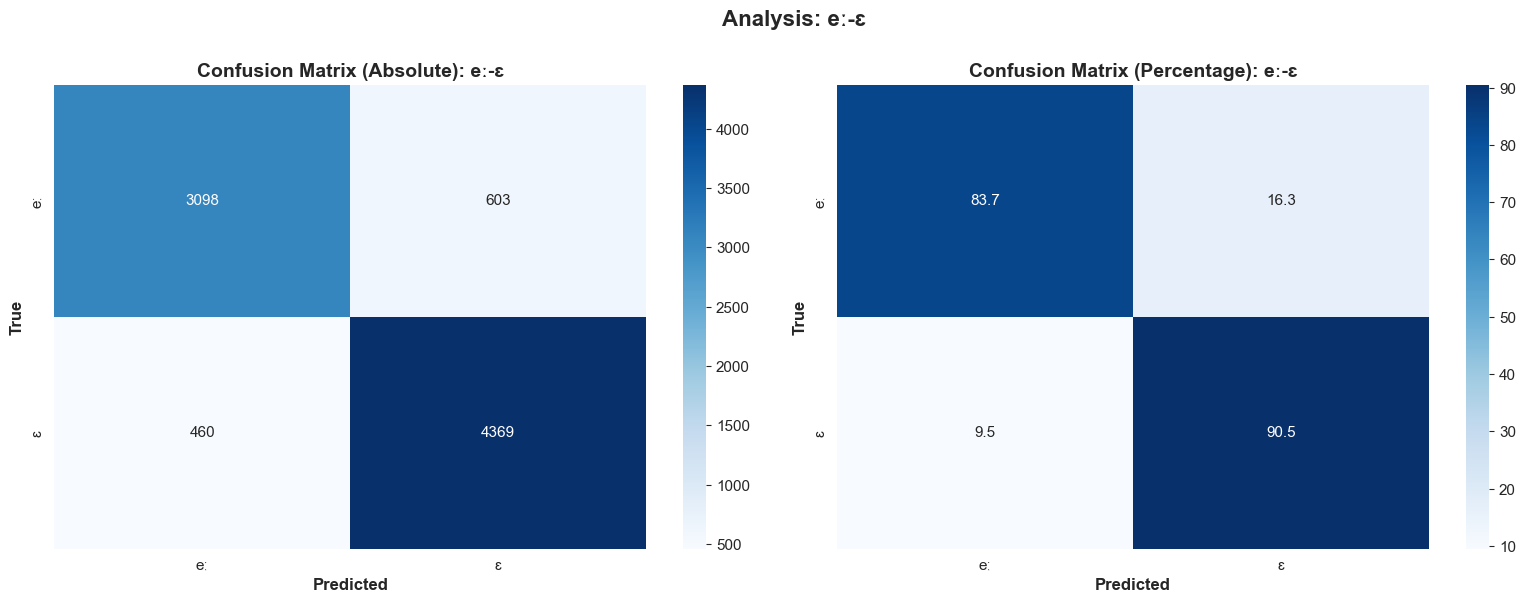


Classification Report:
              precision    recall  f1-score   support

          eː     0.8707    0.8371    0.8536      3701
           ɛ     0.8787    0.9047    0.8915      4829

    accuracy                         0.8754      8530
   macro avg     0.8747    0.8709    0.8726      8530
weighted avg     0.8752    0.8754    0.8751      8530


Total misclassifications: 1063

Misclassifications by true class:
  eː: 603/3701 (16.29%)
  ɛ: 460/4829 (9.53%)

Probability Statistics:
Correct predictions:
  Mean: 0.7470, Median: 0.7644, Std: 0.1065
Incorrect predictions:
  Mean: 0.6169, Median: 0.5984, Std: 0.0873

DETAILED MISCLASSIFICATION ANALYSIS: eː-ɛ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
       4501         eː               ɛ  0.912144
      56387         eː               ɛ  0.883391
      48856         eː               ɛ  0.865970
      34493         eː               ɛ  0.864112
      51218       

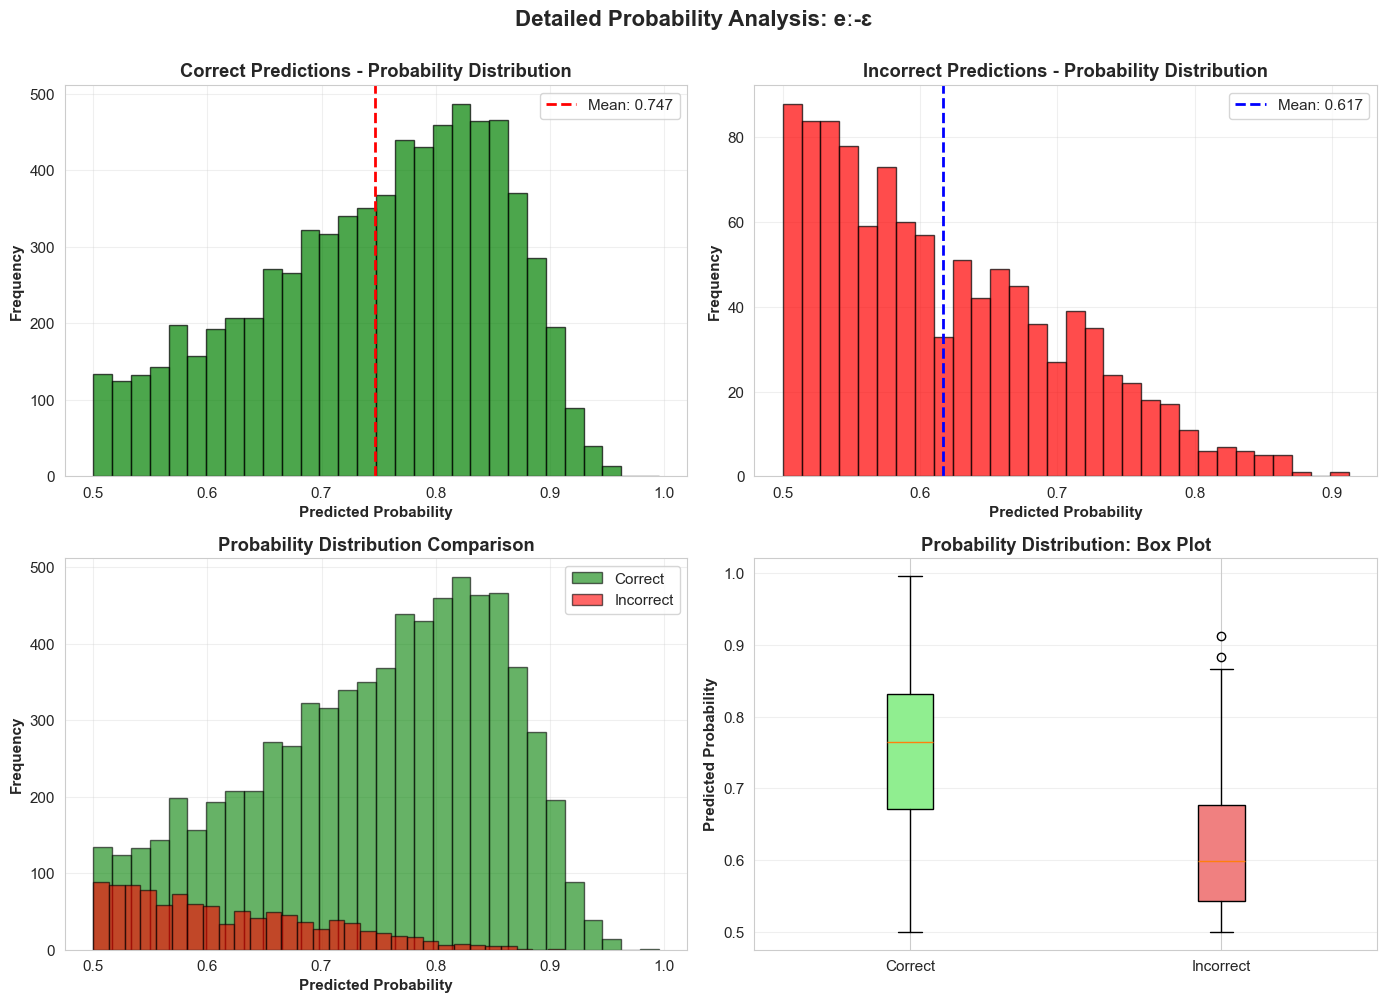




Analyzing: g-k (Velar Plosives)

Loaded 5698 predictions
Correct: 5416, Incorrect: 282

Model Performance:
  Accuracy: 0.9505
  F1-score: 0.9504
  Precision: 0.9505
  Recall: 0.9505
  ROC-AUC: 0.9904


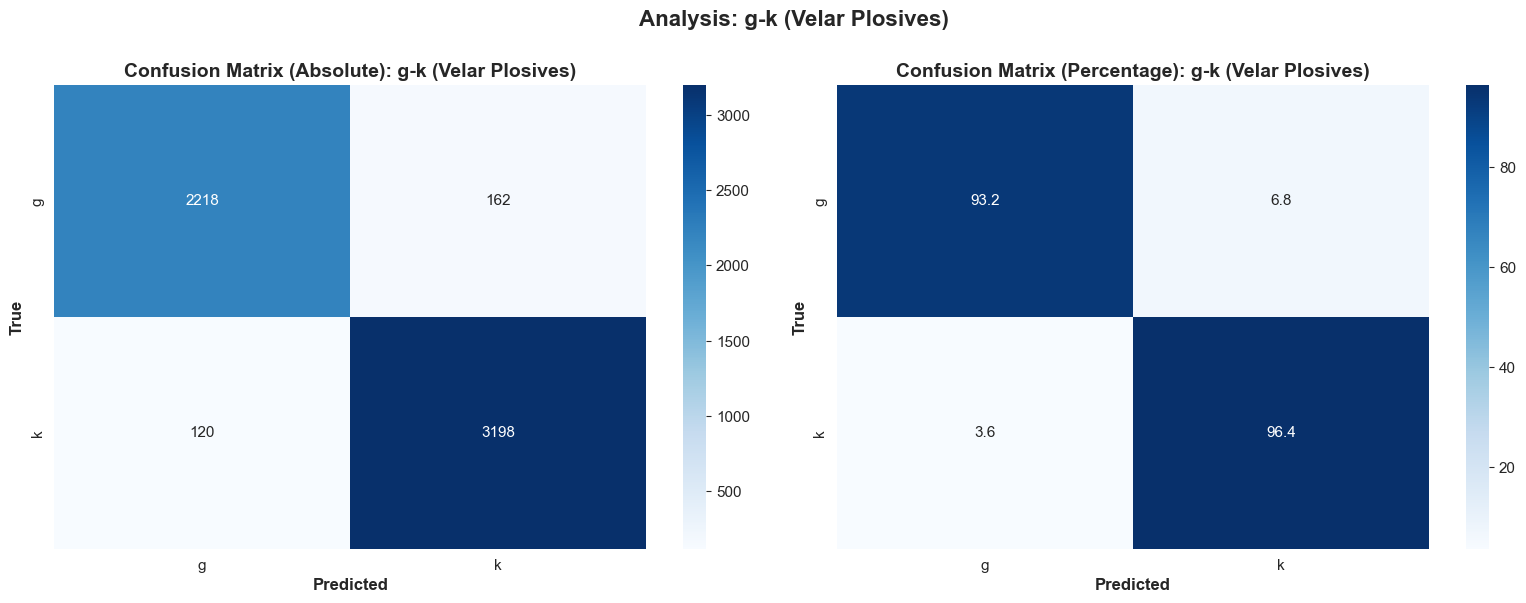


Classification Report:
              precision    recall  f1-score   support

           g     0.9487    0.9319    0.9402      2380
           k     0.9518    0.9638    0.9578      3318

    accuracy                         0.9505      5698
   macro avg     0.9502    0.9479    0.9490      5698
weighted avg     0.9505    0.9505    0.9504      5698


Total misclassifications: 282

Misclassifications by true class:
  g: 0/0 (0.00%)
  k: 162/2380 (6.81%)

Probability Statistics:
Correct predictions:
  Mean: 0.8890, Median: 0.9155, Std: 0.0950
Incorrect predictions:
  Mean: 0.6558, Median: 0.6265, Std: 0.1188

DETAILED MISCLASSIFICATION ANALYSIS: g-k (Velar Plosives)

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      18863          ɡ               k  0.949325
       5853          ɡ               k  0.941366
      32699          ɡ               k  0.924684
      13606          ɡ               k  0.923862
       833

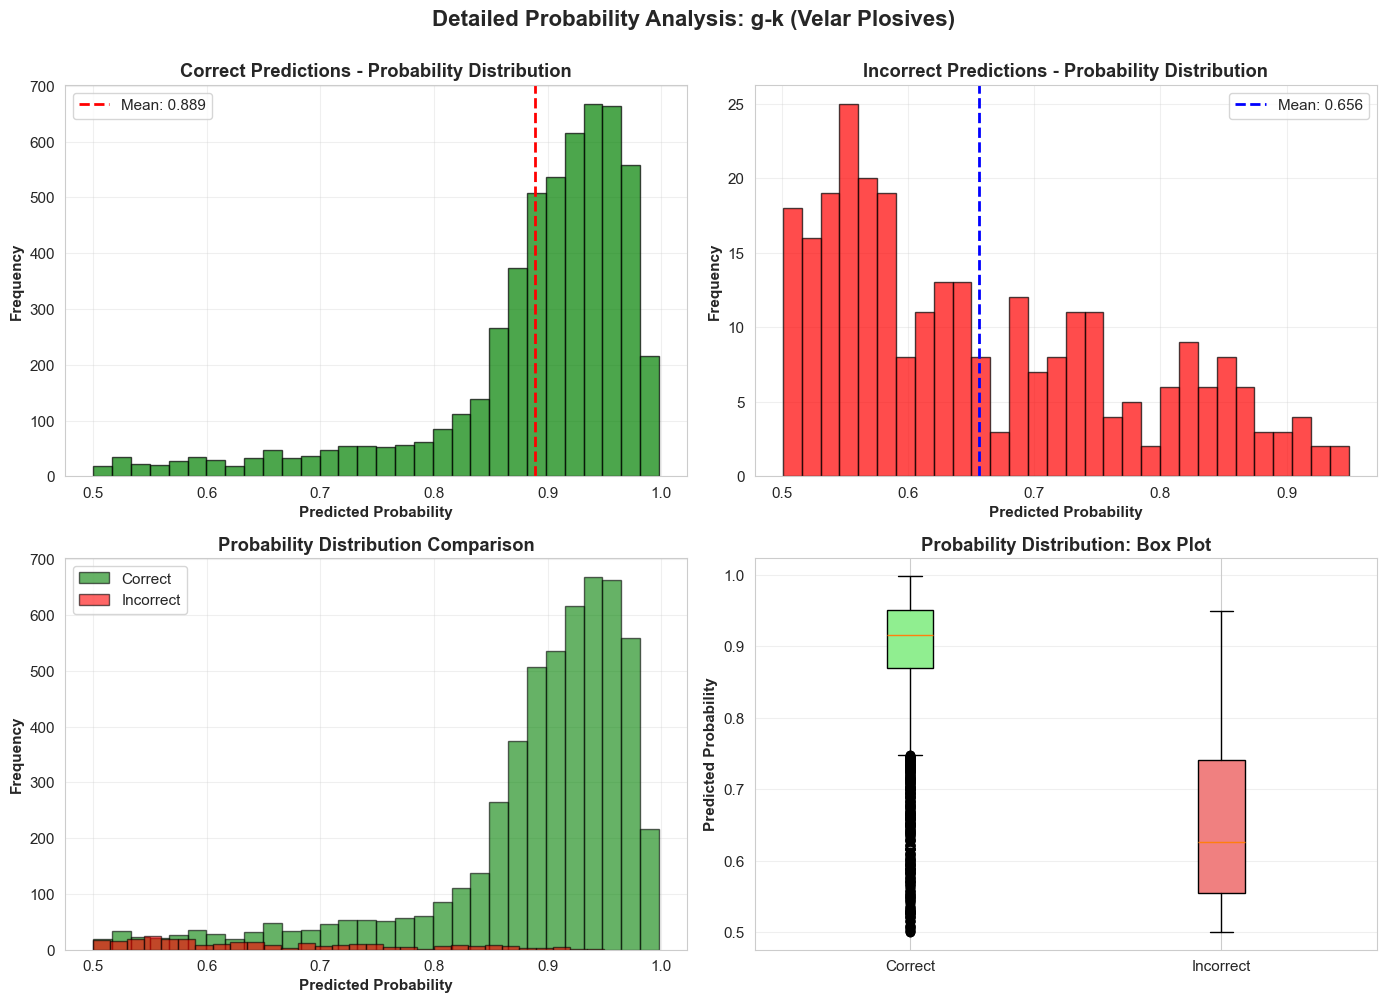




Analyzing: iː-ɪ

Loaded 8530 predictions
Correct: 7802, Incorrect: 728

Model Performance:
  Accuracy: 0.9147
  F1-score: 0.9150
  Precision: 0.9155
  Recall: 0.9147
  ROC-AUC: 0.9678


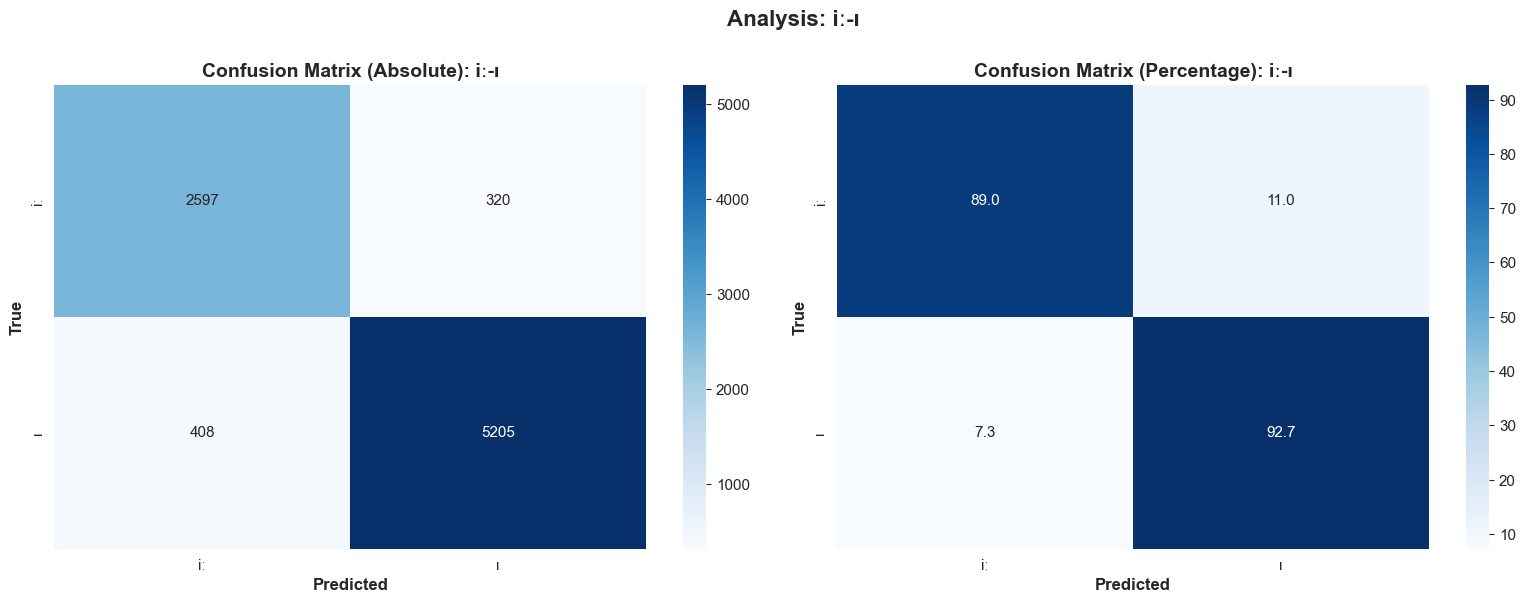


Classification Report:
              precision    recall  f1-score   support

          iː     0.8642    0.8903    0.8771      2917
           ɪ     0.9421    0.9273    0.9346      5613

    accuracy                         0.9147      8530
   macro avg     0.9032    0.9088    0.9059      8530
weighted avg     0.9155    0.9147    0.9150      8530


Total misclassifications: 728

Misclassifications by true class:
  iː: 320/2917 (10.97%)
  ɪ: 408/5613 (7.27%)

Probability Statistics:
Correct predictions:
  Mean: 0.7909, Median: 0.8193, Std: 0.1052
Incorrect predictions:
  Mean: 0.6290, Median: 0.6189, Std: 0.0940

DETAILED MISCLASSIFICATION ANALYSIS: iː-ɪ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      19054         iː               ɪ  0.886609
      56728         iː               ɪ  0.886422
      10681         iː               ɪ  0.872318
      53357          ɪ              iː  0.863778
      20646        

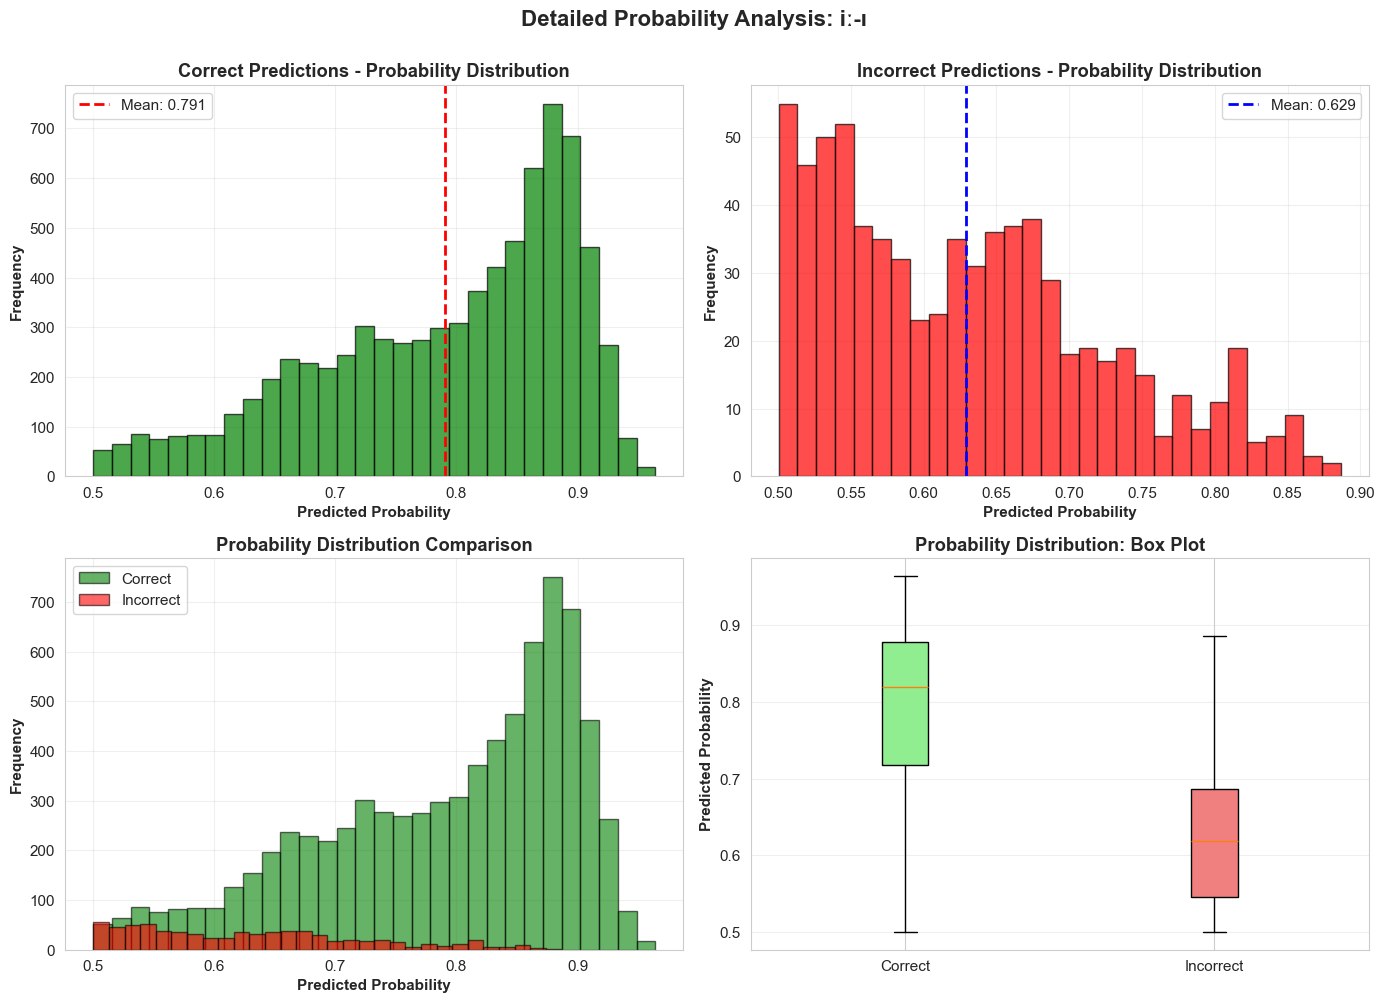




Analyzing: kʰ-g

Loaded 5192 predictions
Correct: 4944, Incorrect: 248

Model Performance:
  Accuracy: 0.9522
  F1-score: 0.9525
  Precision: 0.9532
  Recall: 0.9522
  ROC-AUC: 0.9882


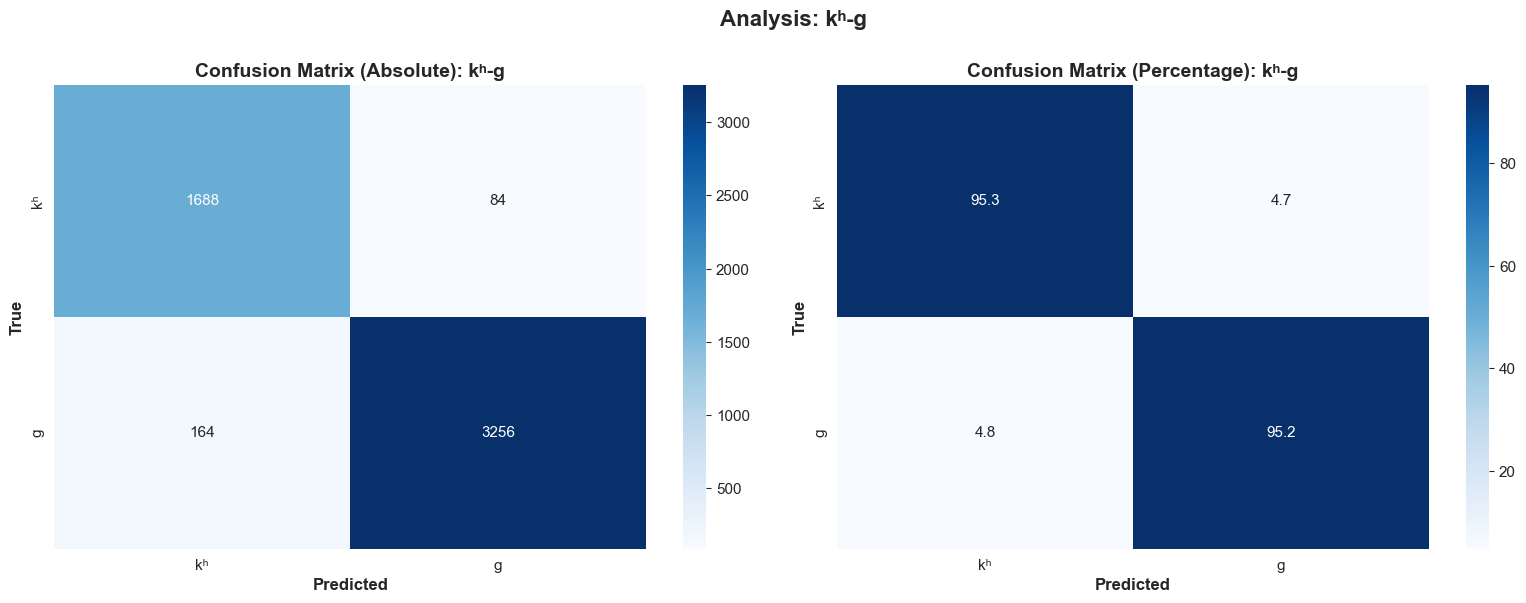


Classification Report:
              precision    recall  f1-score   support

          kʰ     0.9114    0.9526    0.9316      1772
           ɡ     0.9749    0.9520    0.9633      3420

    accuracy                         0.9522      5192
   macro avg     0.9431    0.9523    0.9474      5192
weighted avg     0.9532    0.9522    0.9525      5192


Total misclassifications: 248

Misclassifications by true class:
  kʰ: 84/1772 (4.74%)
  ɡ: 164/3420 (4.80%)

Probability Statistics:
Correct predictions:
  Mean: 0.8692, Median: 0.9022, Std: 0.1054
Incorrect predictions:
  Mean: 0.6622, Median: 0.6265, Std: 0.1295

DETAILED MISCLASSIFICATION ANALYSIS: kʰ-g

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      12889          ɡ              kʰ  0.981935
       1788          ɡ              kʰ  0.964330
      26828          ɡ              kʰ  0.946979
       4741          ɡ              kʰ  0.941170
      16112          

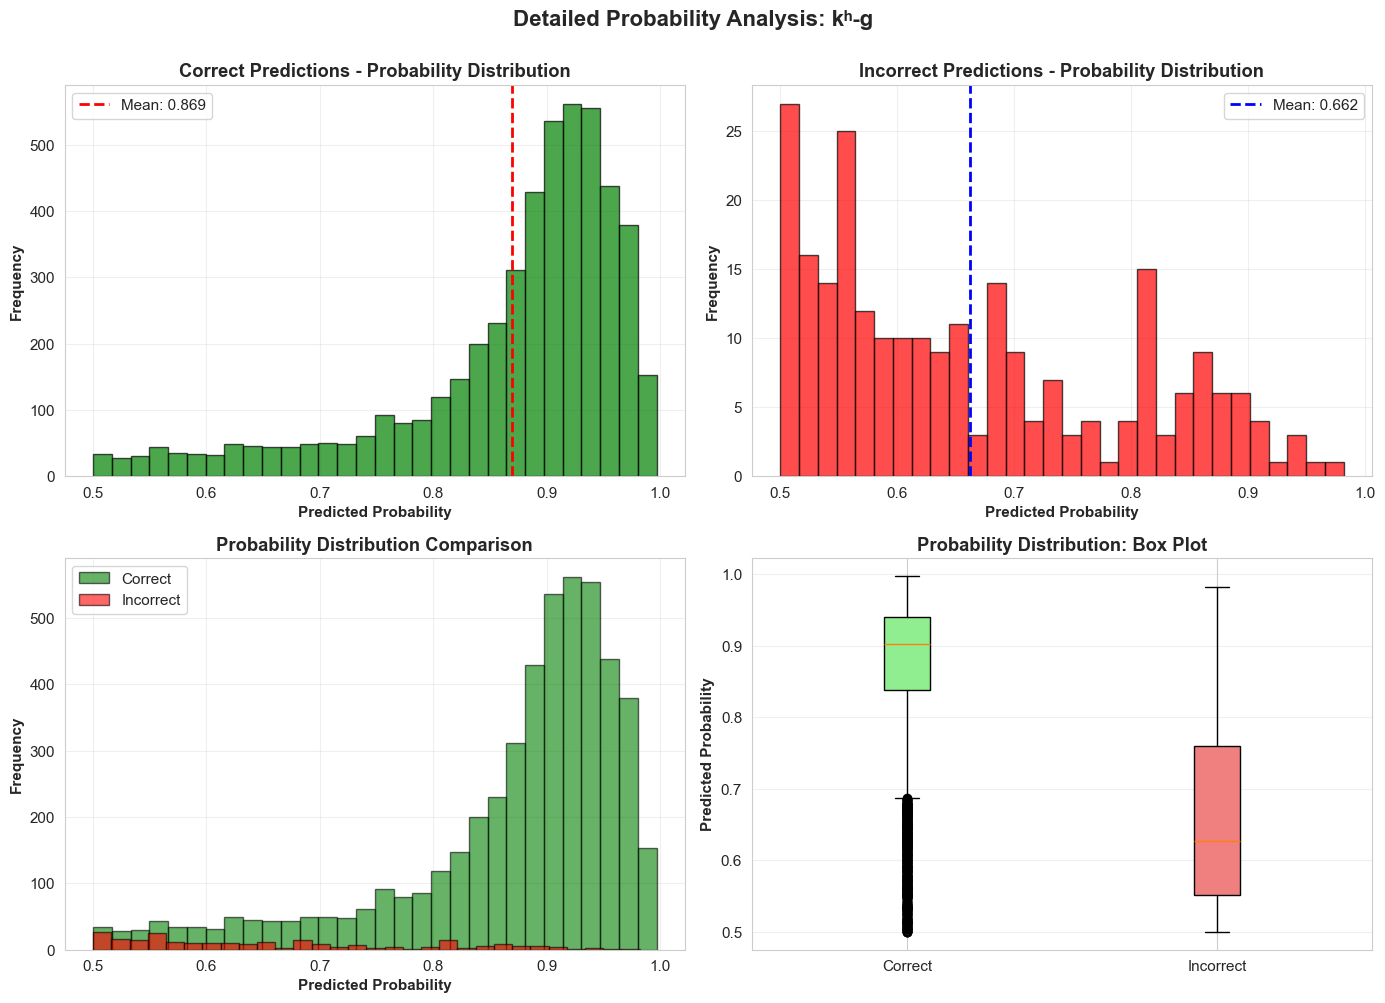




Analyzing: oː-ɔ

Loaded 5523 predictions
Correct: 4945, Incorrect: 578

Model Performance:
  Accuracy: 0.8953
  F1-score: 0.8959
  Precision: 0.8974
  Recall: 0.8953
  ROC-AUC: 0.9569


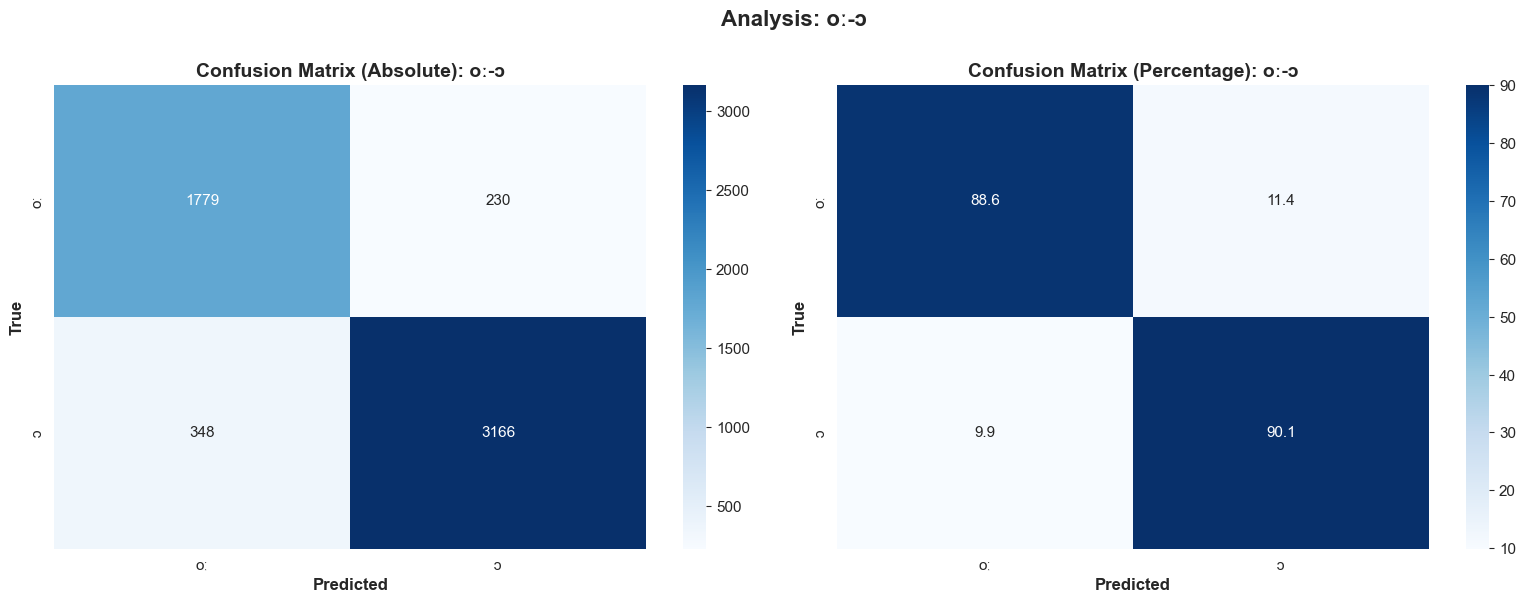


Classification Report:
              precision    recall  f1-score   support

          oː     0.8364    0.8855    0.8603      2009
           ɔ     0.9323    0.9010    0.9164      3514

    accuracy                         0.8953      5523
   macro avg     0.8843    0.8932    0.8883      5523
weighted avg     0.8974    0.8953    0.8959      5523


Total misclassifications: 578

Misclassifications by true class:
  oː: 230/2009 (11.45%)
  ɔ: 348/3514 (9.90%)

Probability Statistics:
Correct predictions:
  Mean: 0.8230, Median: 0.8476, Std: 0.1108
Incorrect predictions:
  Mean: 0.6702, Median: 0.6620, Std: 0.1087

DETAILED MISCLASSIFICATION ANALYSIS: oː-ɔ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      12294         oː               ɔ  0.963983
      34915         oː               ɔ  0.949599
      27208         oː               ɔ  0.944125
       3186          ɔ              oː  0.941596
      32586        

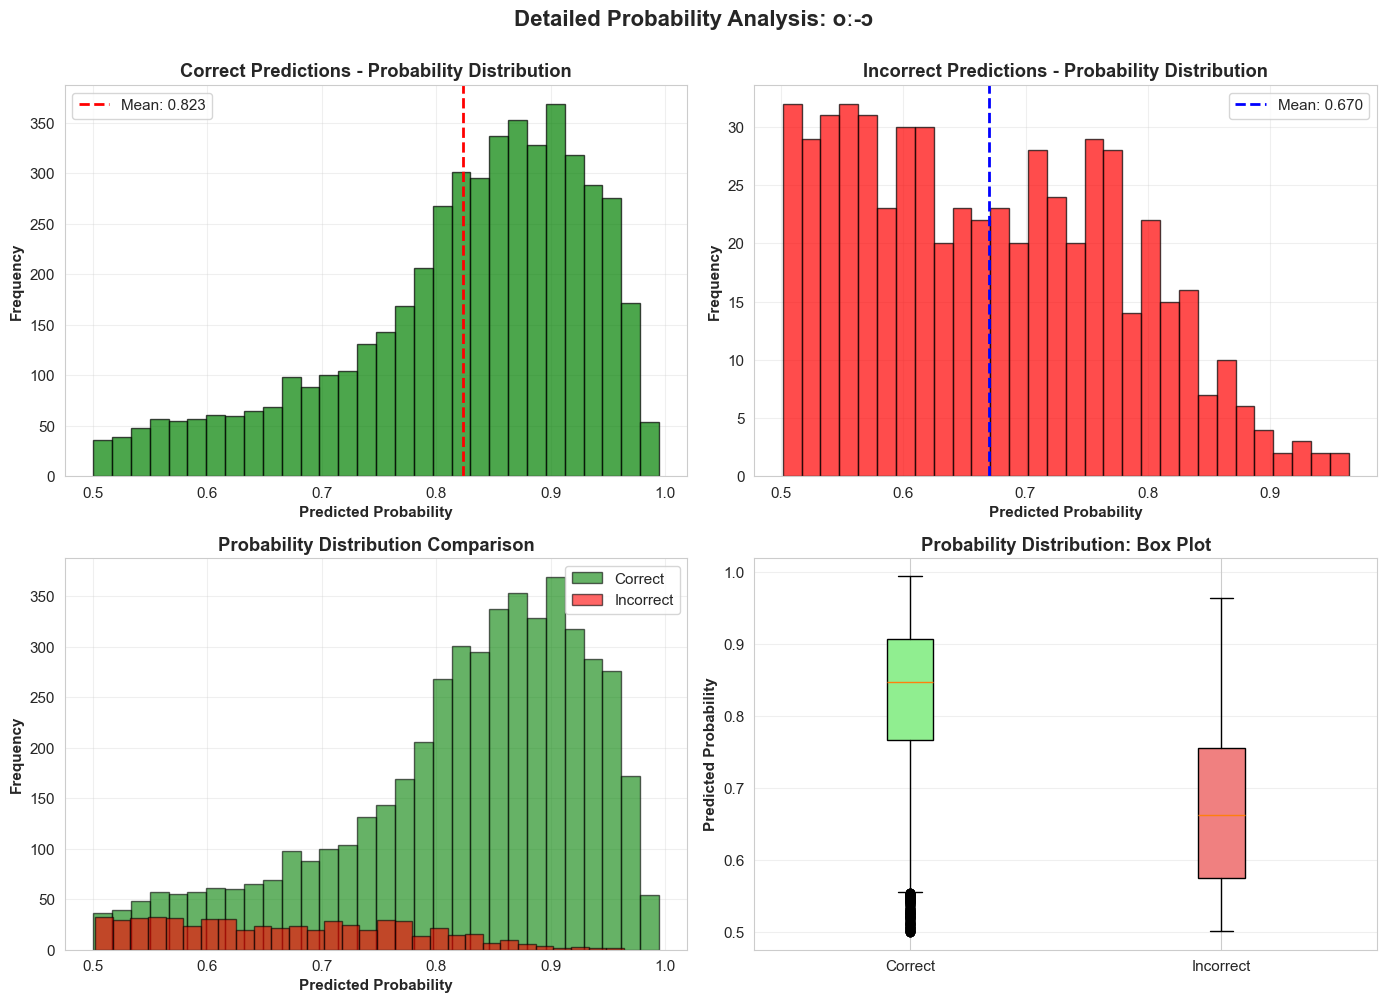




Analyzing: s-ʃ

Loaded 10770 predictions
Correct: 10687, Incorrect: 83

Model Performance:
  Accuracy: 0.9923
  F1-score: 0.9923
  Precision: 0.9923
  Recall: 0.9923
  ROC-AUC: 0.9968


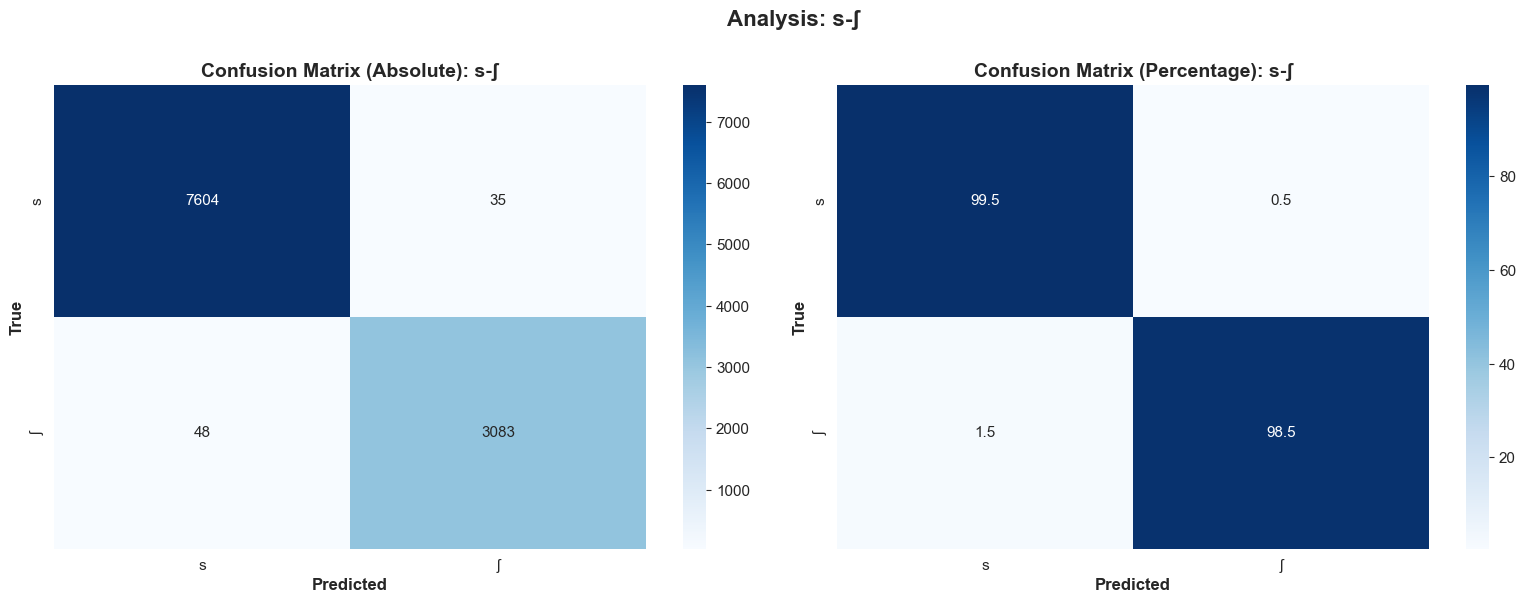


Classification Report:
              precision    recall  f1-score   support

           s     0.9937    0.9954    0.9946      7639
           ʃ     0.9888    0.9847    0.9867      3131

    accuracy                         0.9923     10770
   macro avg     0.9913    0.9900    0.9906     10770
weighted avg     0.9923    0.9923    0.9923     10770


Total misclassifications: 83

Misclassifications by true class:
  s: 35/7639 (0.46%)
  ʃ: 48/3131 (1.53%)

Probability Statistics:
Correct predictions:
  Mean: 0.9061, Median: 0.9186, Std: 0.0511
Incorrect predictions:
  Mean: 0.7572, Median: 0.7903, Std: 0.1450

DETAILED MISCLASSIFICATION ANALYSIS: s-ʃ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      69897          ʃ               s  0.963257
      15505          ʃ               s  0.946213
       1786          s               ʃ  0.945993
      17251          s               ʃ  0.929499
      19015          ʃ   

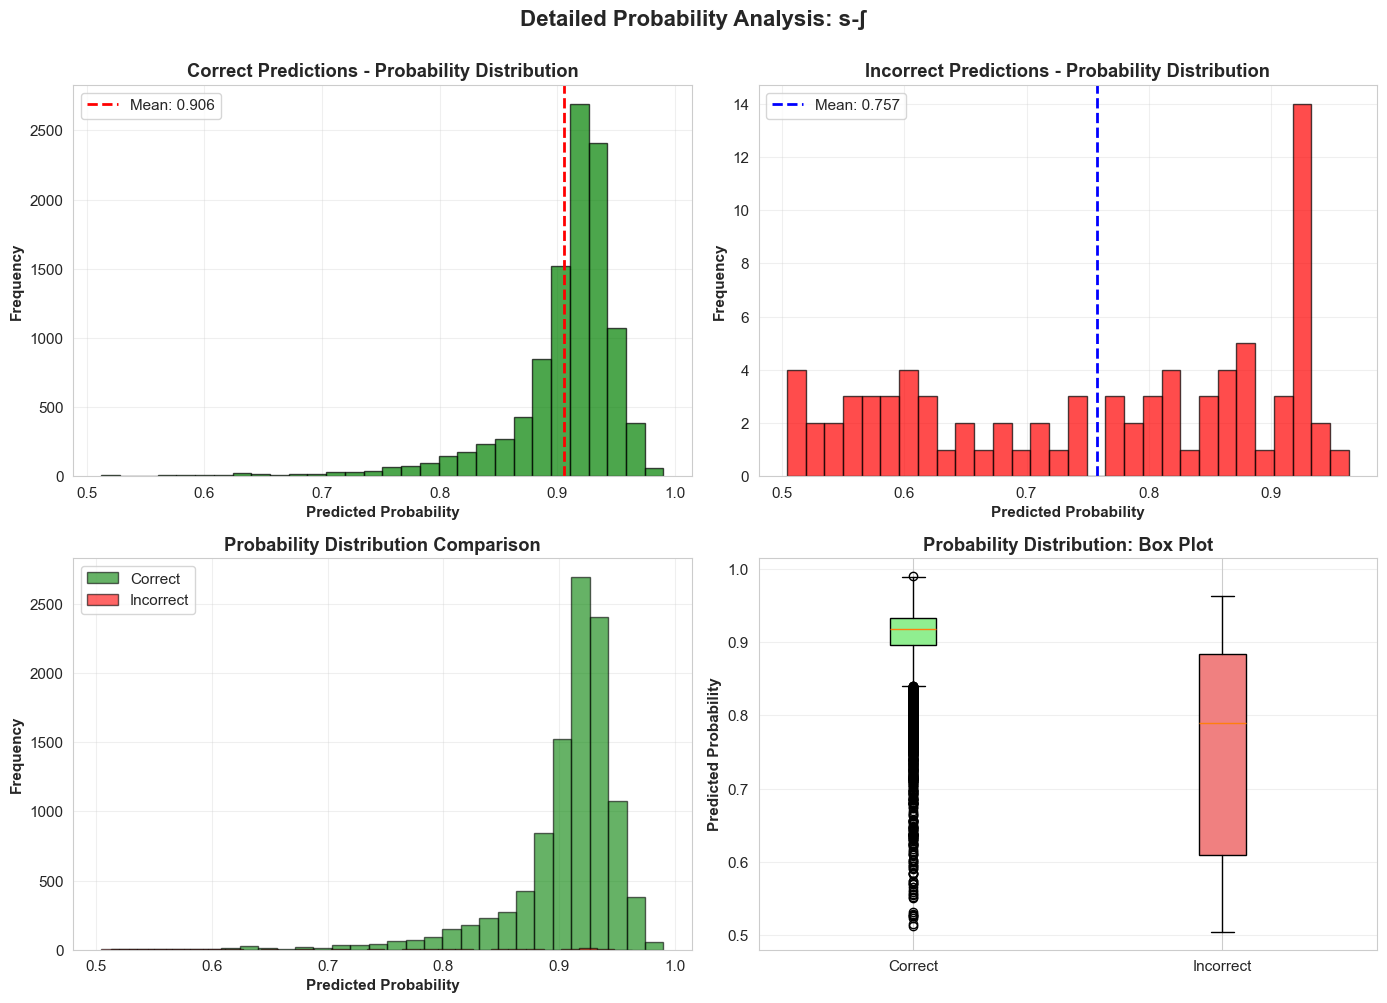




Analyzing: ts-s

Loaded 10395 predictions
Correct: 9892, Incorrect: 503

Model Performance:
  Accuracy: 0.9516
  F1-score: 0.9521
  Precision: 0.9532
  Recall: 0.9516
  ROC-AUC: 0.9902


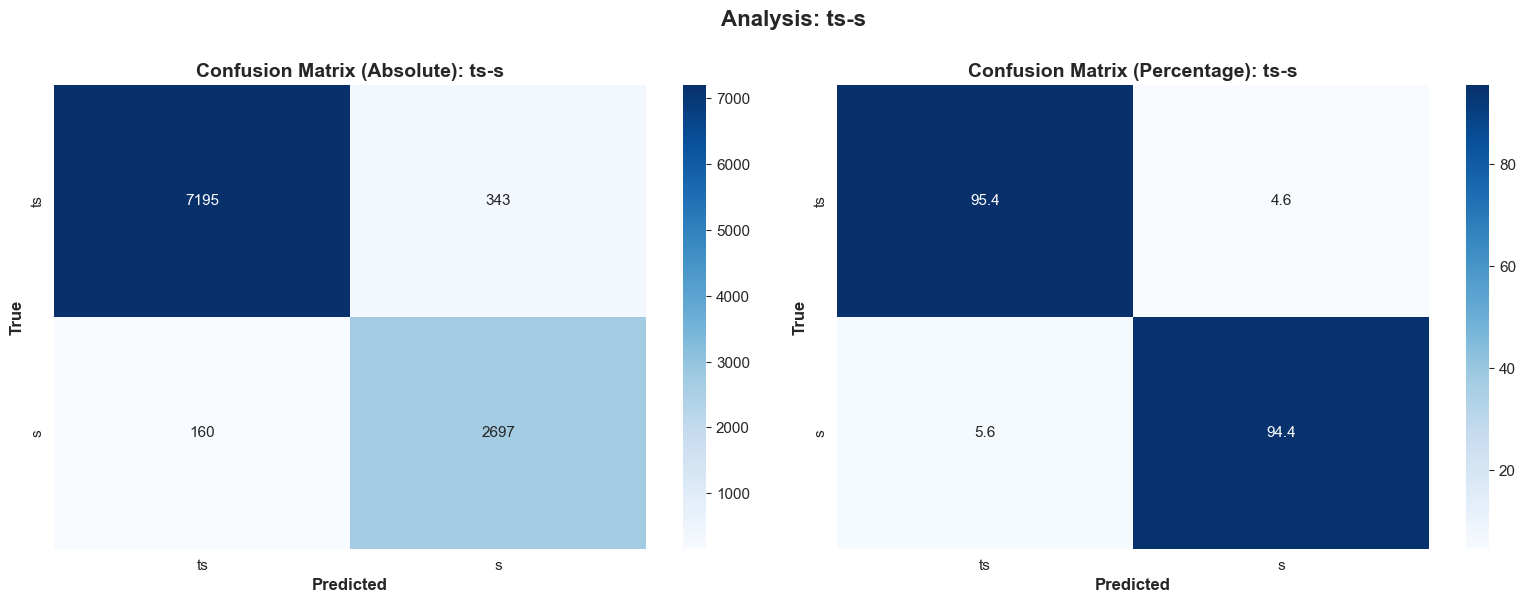


Classification Report:
              precision    recall  f1-score   support

          ts     0.9782    0.9545    0.9662      7538
           s     0.8872    0.9440    0.9147      2857

    accuracy                         0.9516     10395
   macro avg     0.9327    0.9492    0.9405     10395
weighted avg     0.9532    0.9516    0.9521     10395


Total misclassifications: 503

Misclassifications by true class:
  ts: 160/2857 (5.60%)
  s: 343/7538 (4.55%)

Probability Statistics:
Correct predictions:
  Mean: 0.8963, Median: 0.9225, Std: 0.0924
Incorrect predictions:
  Mean: 0.6703, Median: 0.6531, Std: 0.1121

DETAILED MISCLASSIFICATION ANALYSIS: ts-s

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      62395         ts               s  0.985021
       2987         ts               s  0.981584
      50301         ts               s  0.961244
       8891          s              ts  0.949582
      65758         

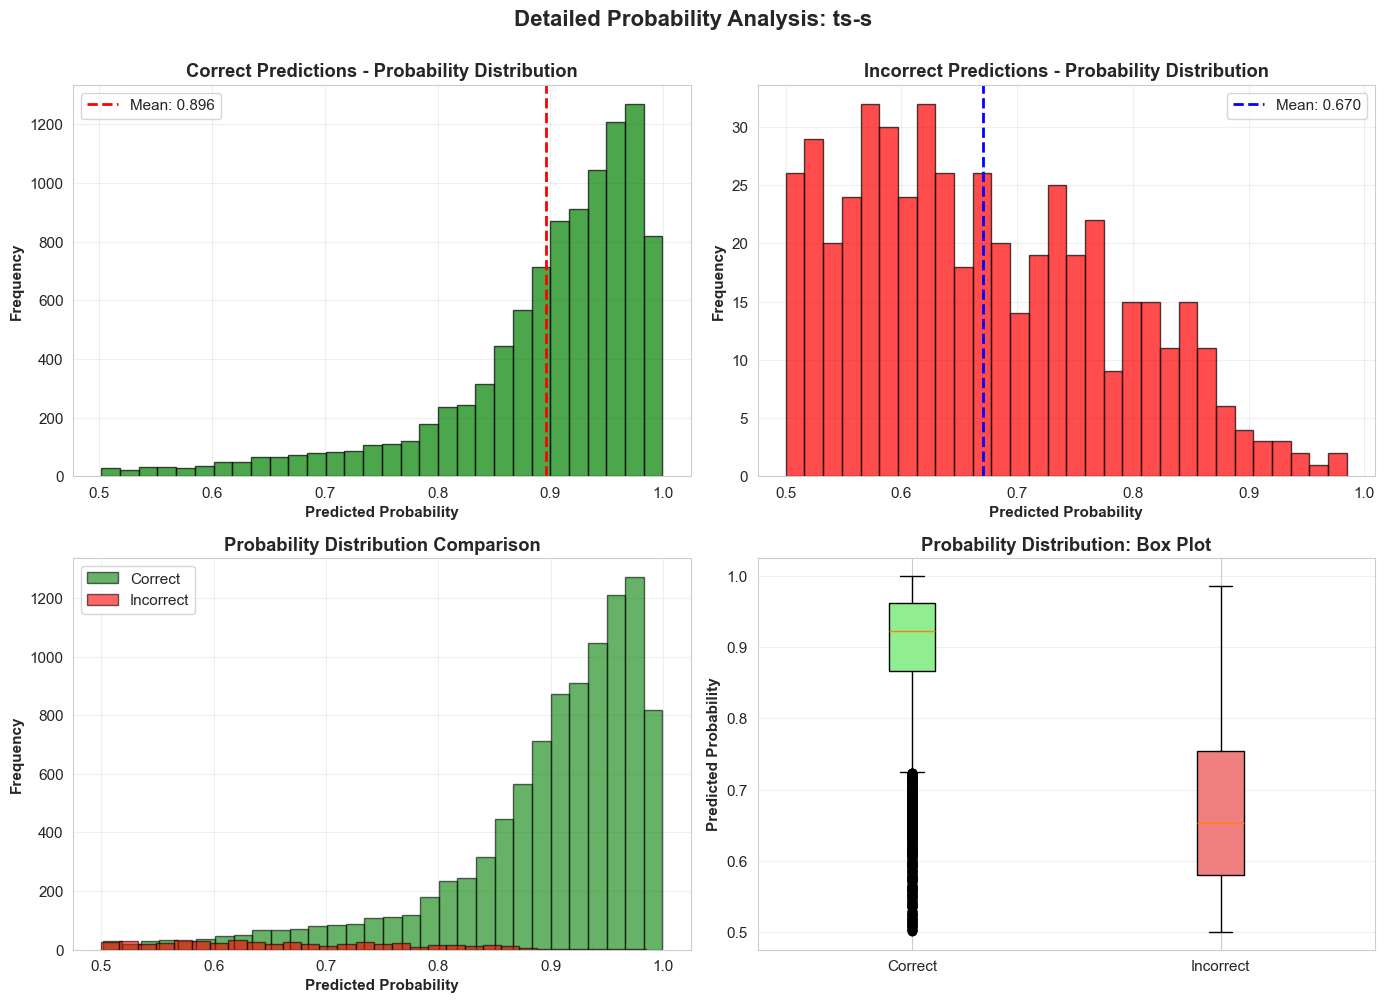




Analyzing: tʰ-d

Loaded 13178 predictions
Correct: 12342, Incorrect: 836

Model Performance:
  Accuracy: 0.9366
  F1-score: 0.9371
  Precision: 0.9390
  Recall: 0.9366
  ROC-AUC: 0.9844


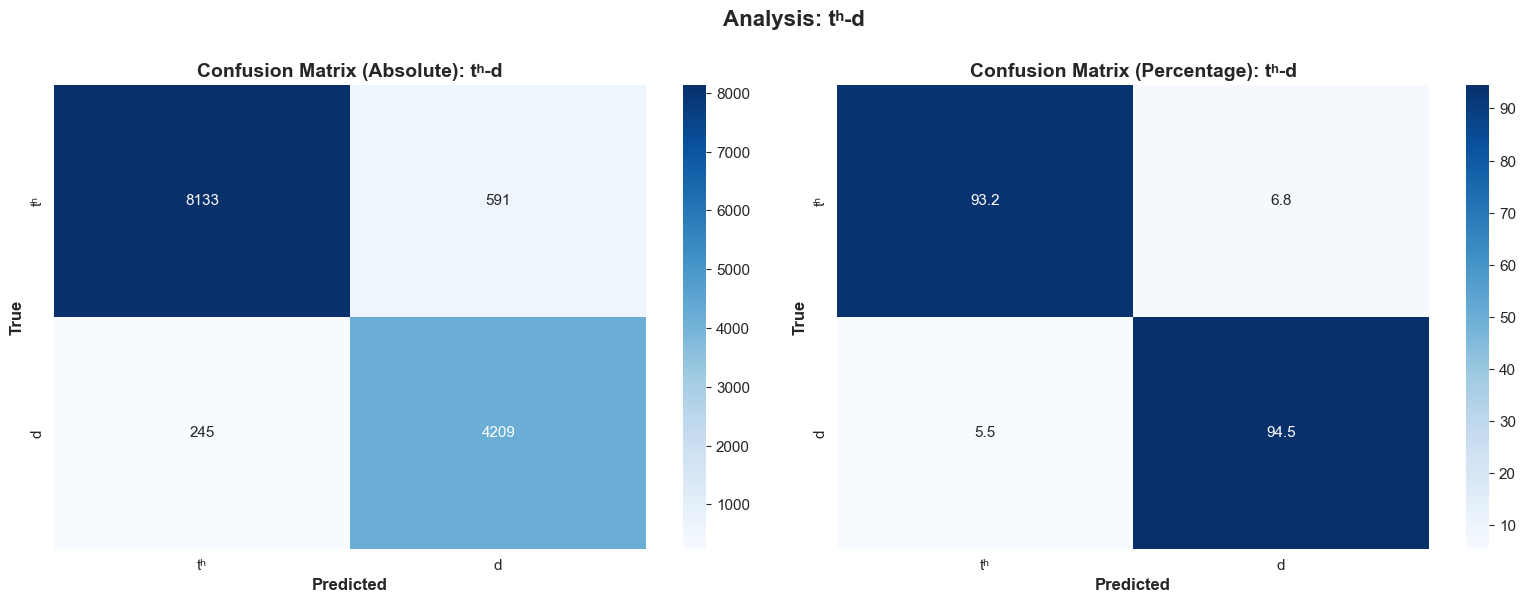


Classification Report:
              precision    recall  f1-score   support

          tʰ     0.9708    0.9323    0.9511      8724
           d     0.8769    0.9450    0.9097      4454

    accuracy                         0.9366     13178
   macro avg     0.9238    0.9386    0.9304     13178
weighted avg     0.9390    0.9366    0.9371     13178


Total misclassifications: 836

Misclassifications by true class:
  tʰ: 245/4454 (5.50%)
  d: 591/8724 (6.77%)

Probability Statistics:
Correct predictions:
  Mean: 0.8320, Median: 0.8623, Std: 0.1048
Incorrect predictions:
  Mean: 0.6367, Median: 0.6161, Std: 0.1012

DETAILED MISCLASSIFICATION ANALYSIS: tʰ-d

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      44079          d              tʰ  0.940300
      49110          d              tʰ  0.923605
      76314         tʰ               d  0.921747
      34417          d              tʰ  0.902667
      30538         

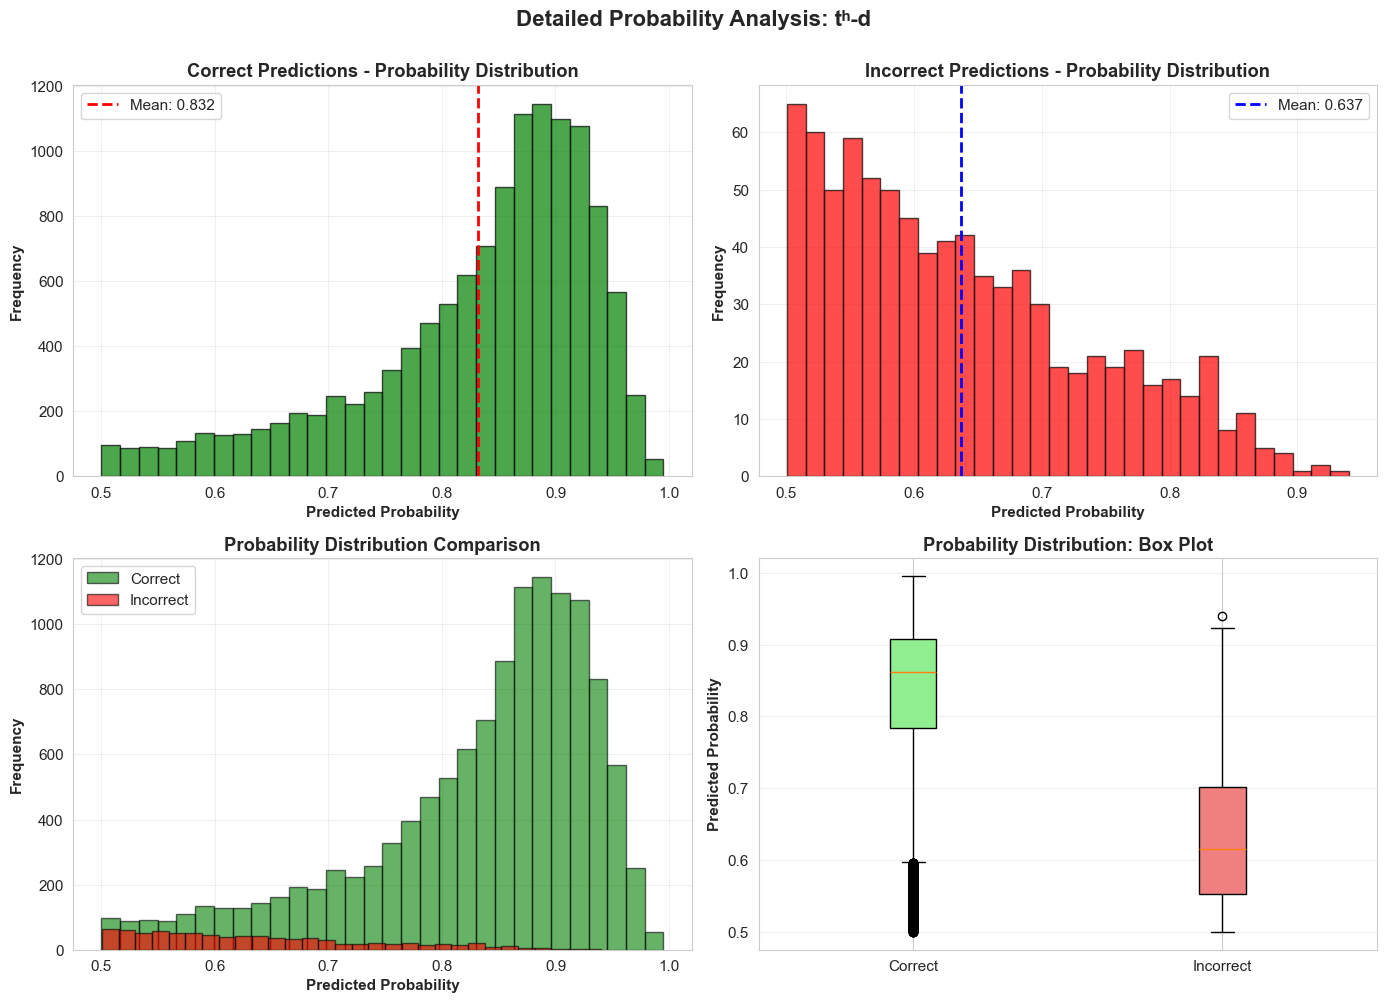




Analyzing: uː-ʊ

Loaded 5638 predictions
Correct: 5125, Incorrect: 513

Model Performance:
  Accuracy: 0.9090
  F1-score: 0.9103
  Precision: 0.9157
  Recall: 0.9090
  ROC-AUC: 0.9685


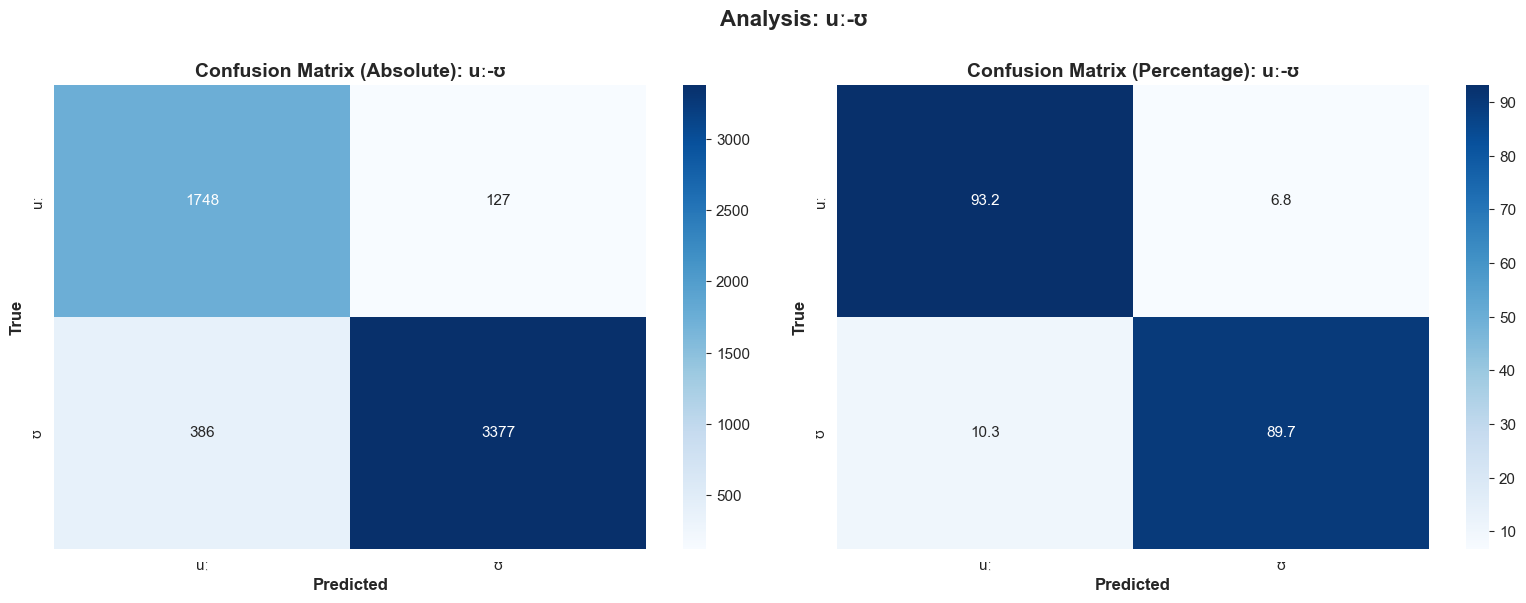


Classification Report:
              precision    recall  f1-score   support

          uː     0.8191    0.9323    0.8720      1875
           ʊ     0.9638    0.8974    0.9294      3763

    accuracy                         0.9090      5638
   macro avg     0.8914    0.9148    0.9007      5638
weighted avg     0.9157    0.9090    0.9103      5638


Total misclassifications: 513

Misclassifications by true class:
  uː: 127/1875 (6.77%)
  ʊ: 386/3763 (10.26%)

Probability Statistics:
Correct predictions:
  Mean: 0.8301, Median: 0.8428, Std: 0.0993
Incorrect predictions:
  Mean: 0.6848, Median: 0.6882, Std: 0.1024

DETAILED MISCLASSIFICATION ANALYSIS: uː-ʊ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      28027         uː               ʊ  0.952170
      25373         uː               ʊ  0.940830
      26632         uː               ʊ  0.891788
      11627         uː               ʊ  0.887421
      24664        

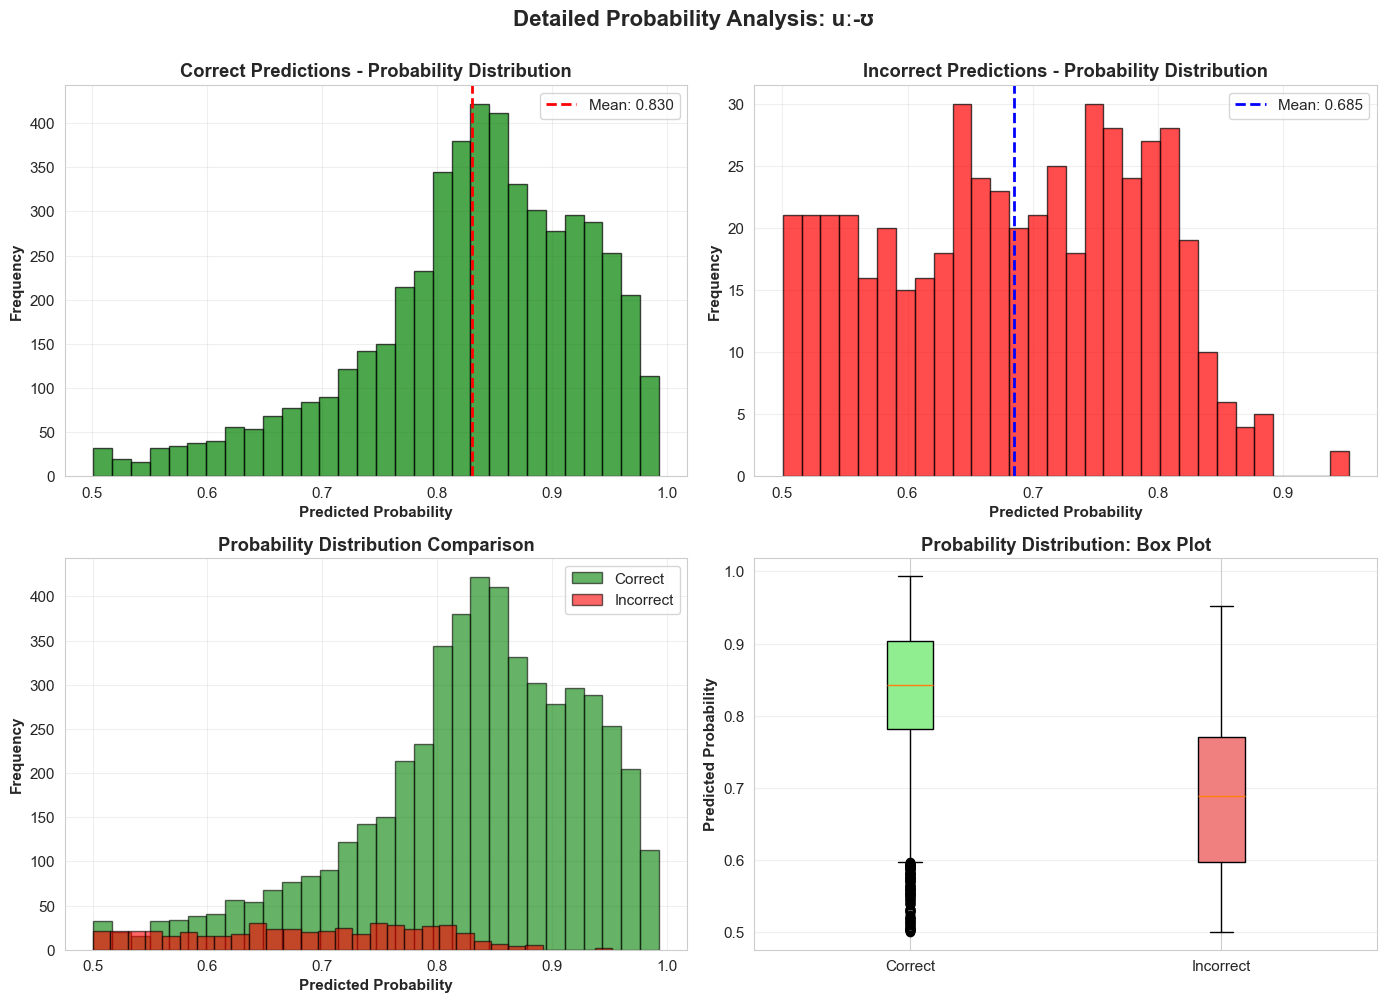




Analyzing: x-k

Loaded 3967 predictions
Correct: 3955, Incorrect: 12

Model Performance:
  Accuracy: 0.9970
  F1-score: 0.9970
  Precision: 0.9970
  Recall: 0.9970
  ROC-AUC: 0.9999


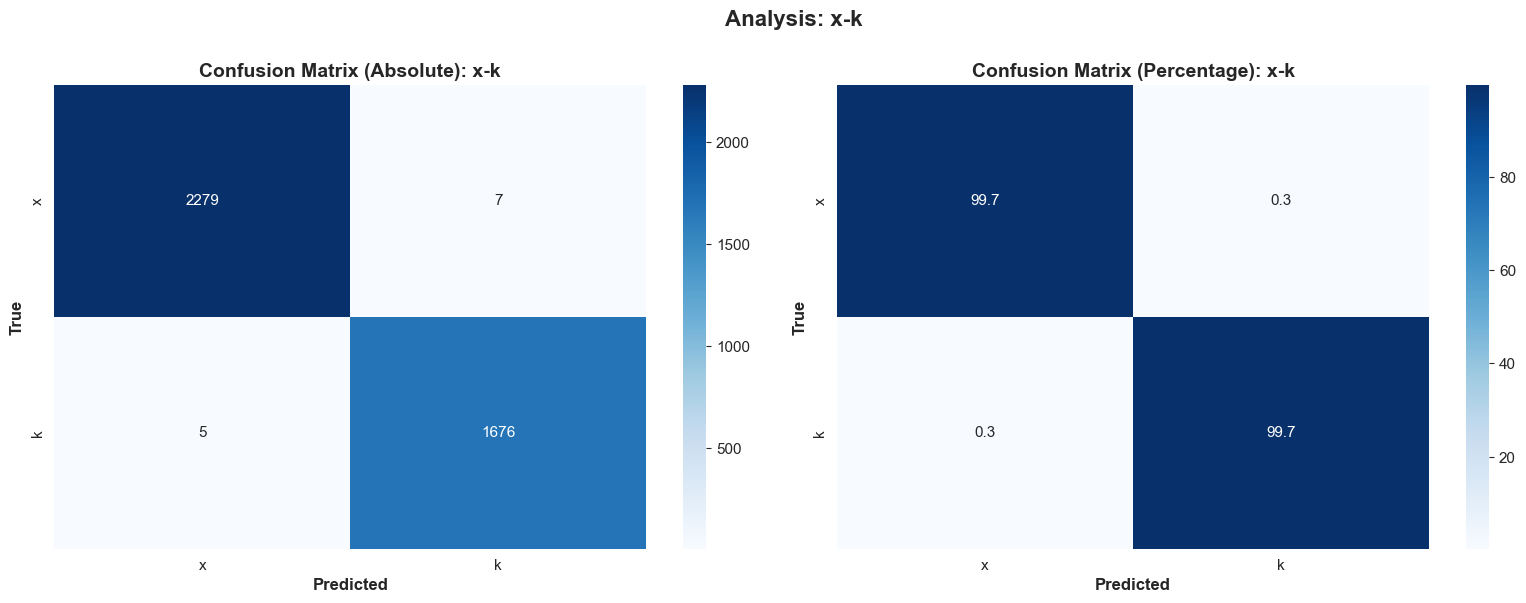


Classification Report:
              precision    recall  f1-score   support

           x     0.9978    0.9969    0.9974      2286
           k     0.9958    0.9970    0.9964      1681

    accuracy                         0.9970      3967
   macro avg     0.9968    0.9970    0.9969      3967
weighted avg     0.9970    0.9970    0.9970      3967


Total misclassifications: 12

Misclassifications by true class:
  x: 5/1681 (0.30%)
  k: 7/2286 (0.31%)

Probability Statistics:
Correct predictions:
  Mean: 0.9352, Median: 0.9372, Std: 0.0373
Incorrect predictions:
  Mean: 0.7314, Median: 0.7528, Std: 0.1277

DETAILED MISCLASSIFICATION ANALYSIS: x-k

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      13323          k               x  0.892877
      11259          k               x  0.878028
       4765          x               k  0.863532
      23163          k               x  0.814034
       7795          k     

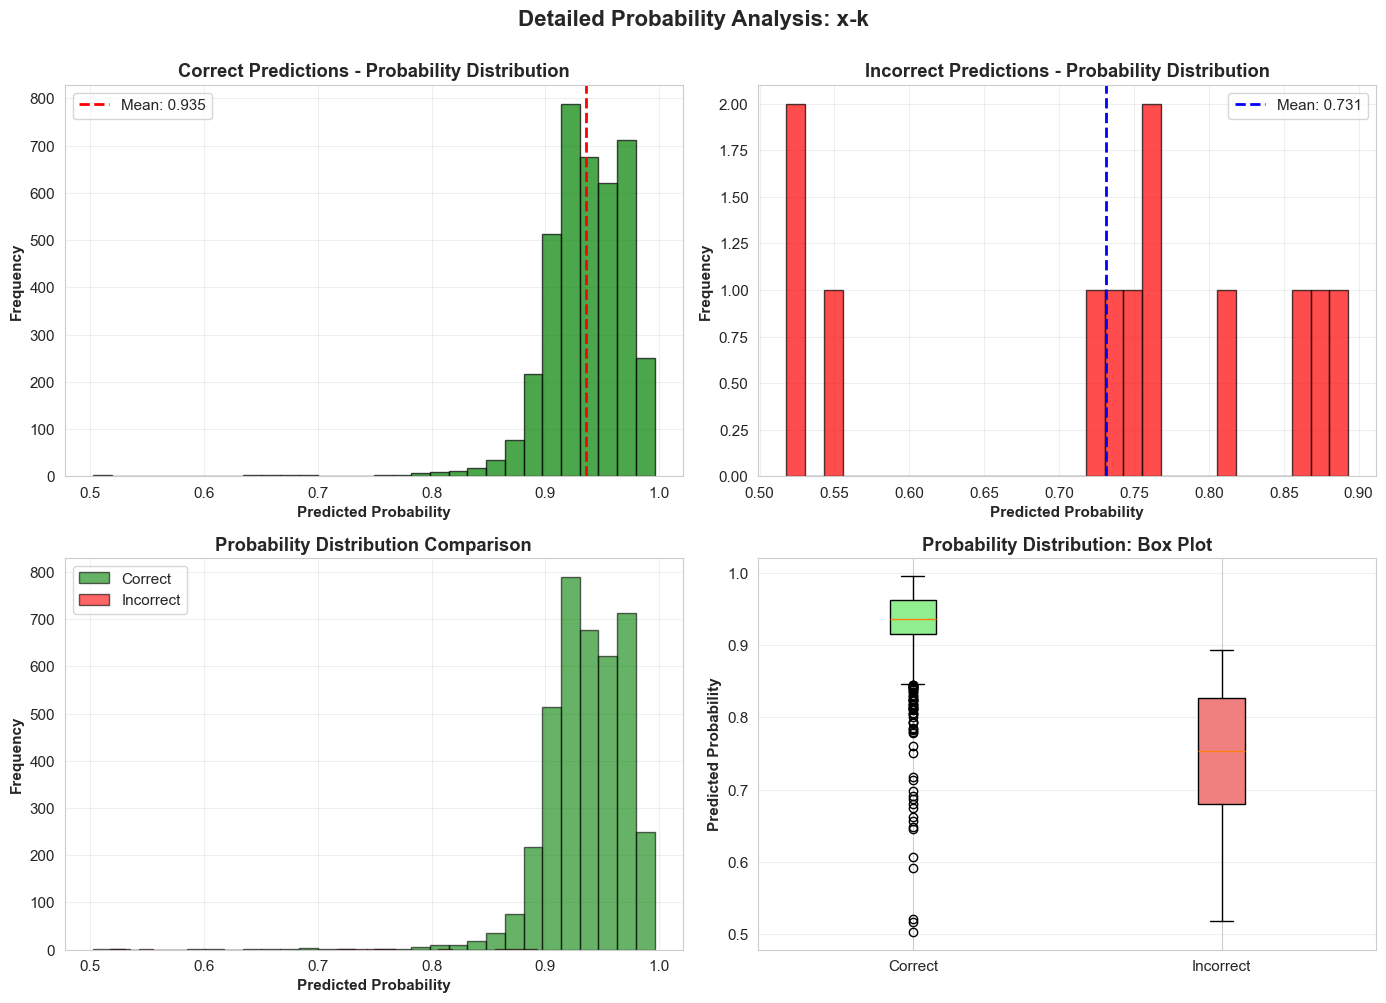




Analyzing: z-s

Loaded 11775 predictions
Correct: 11179, Incorrect: 596

Model Performance:
  Accuracy: 0.9494
  F1-score: 0.9497
  Precision: 0.9512
  Recall: 0.9494
  ROC-AUC: 0.9887


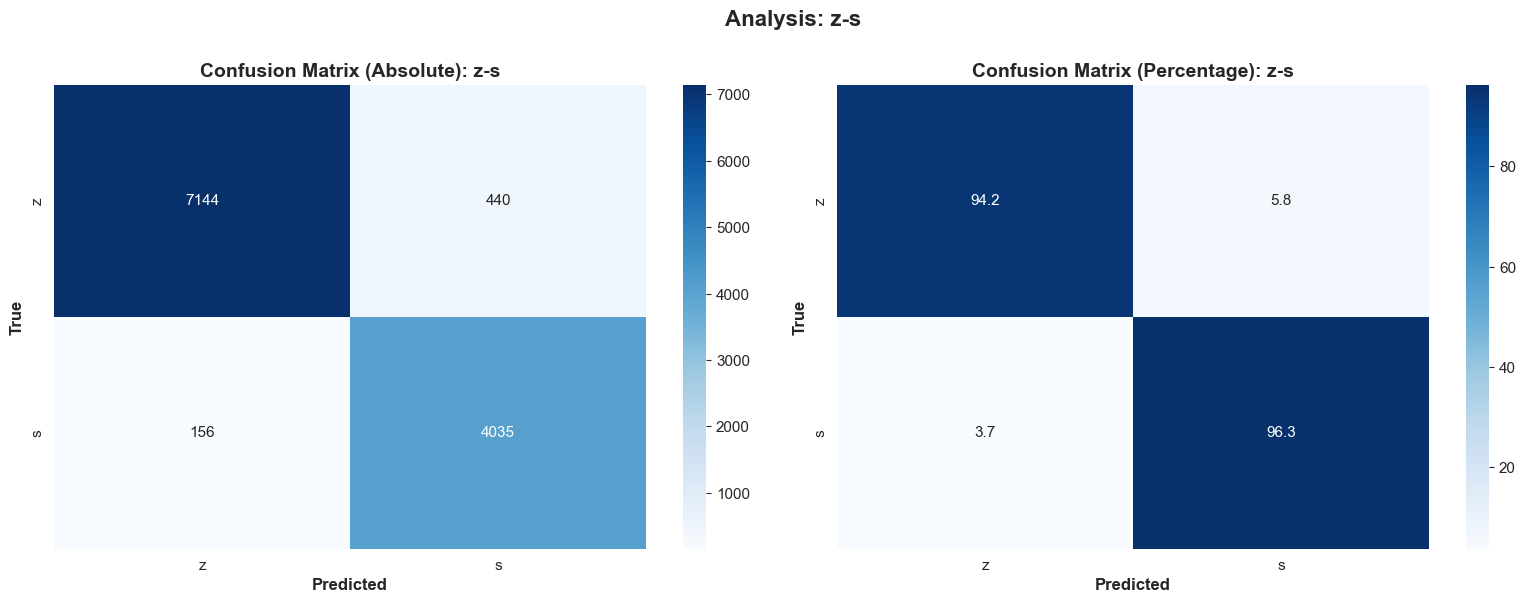


Classification Report:
              precision    recall  f1-score   support

           z     0.9786    0.9420    0.9600      7584
           s     0.9017    0.9628    0.9312      4191

    accuracy                         0.9494     11775
   macro avg     0.9402    0.9524    0.9456     11775
weighted avg     0.9512    0.9494    0.9497     11775


Total misclassifications: 596

Misclassifications by true class:
  z: 156/4191 (3.72%)
  s: 440/7584 (5.80%)

Probability Statistics:
Correct predictions:
  Mean: 0.8349, Median: 0.8585, Std: 0.0948
Incorrect predictions:
  Mean: 0.6488, Median: 0.6417, Std: 0.0990

DETAILED MISCLASSIFICATION ANALYSIS: z-s

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      62449          s               z  0.937231
       4729          z               s  0.926145
       7606          s               z  0.908636
      28525          s               z  0.875313
      24923          s

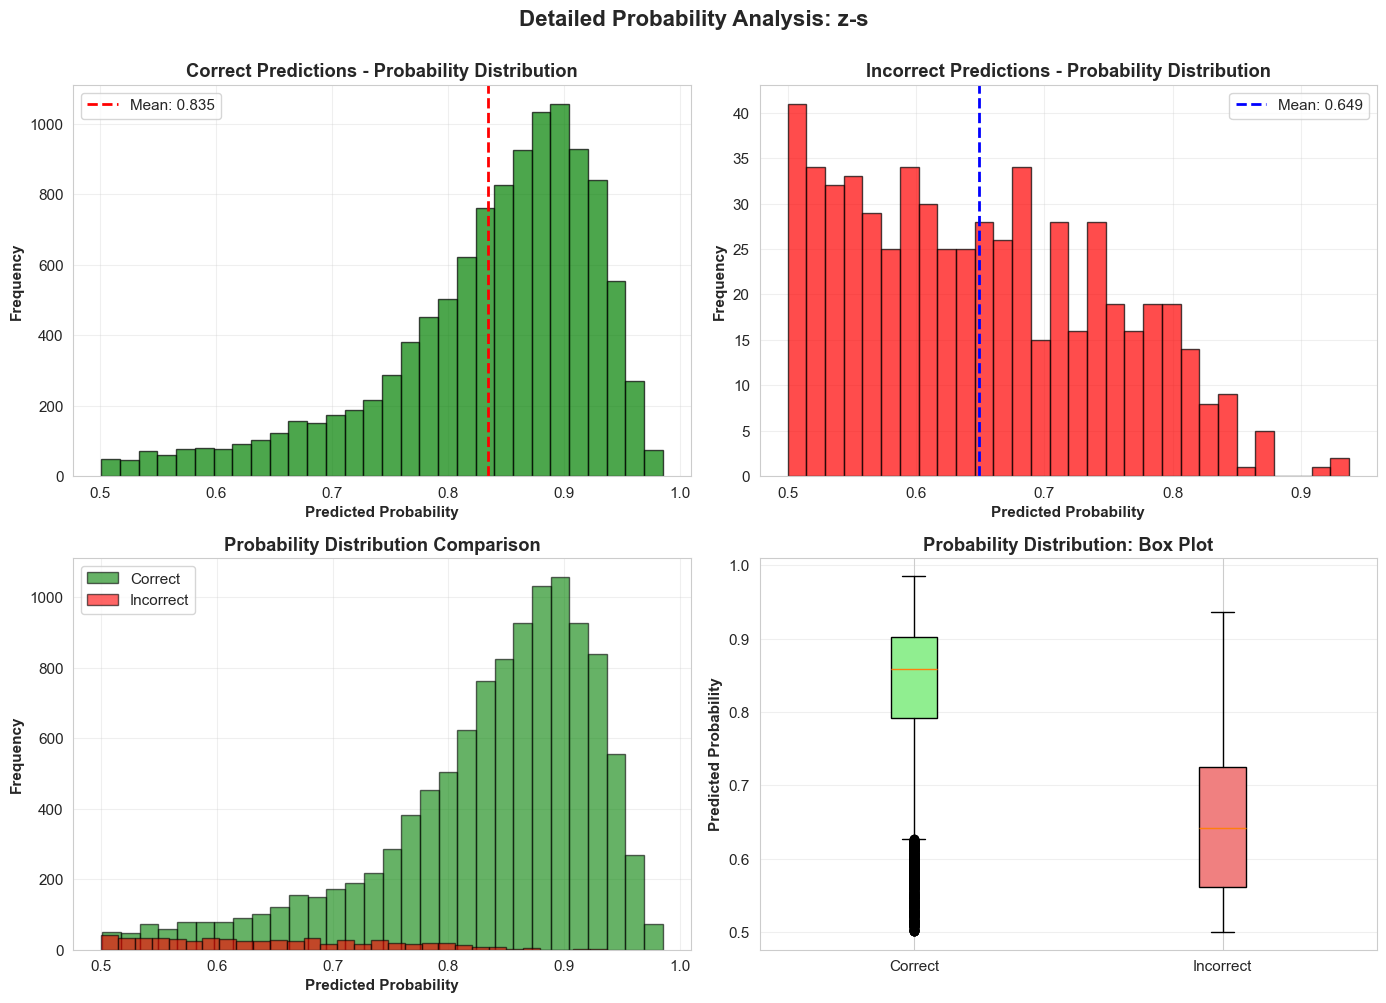




Analyzing: ç-x

Loaded 5698 predictions
Correct: 5694, Incorrect: 4

Model Performance:
  Accuracy: 0.9993
  F1-score: 0.9993
  Precision: 0.9993
  Recall: 0.9993
  ROC-AUC: 1.0000


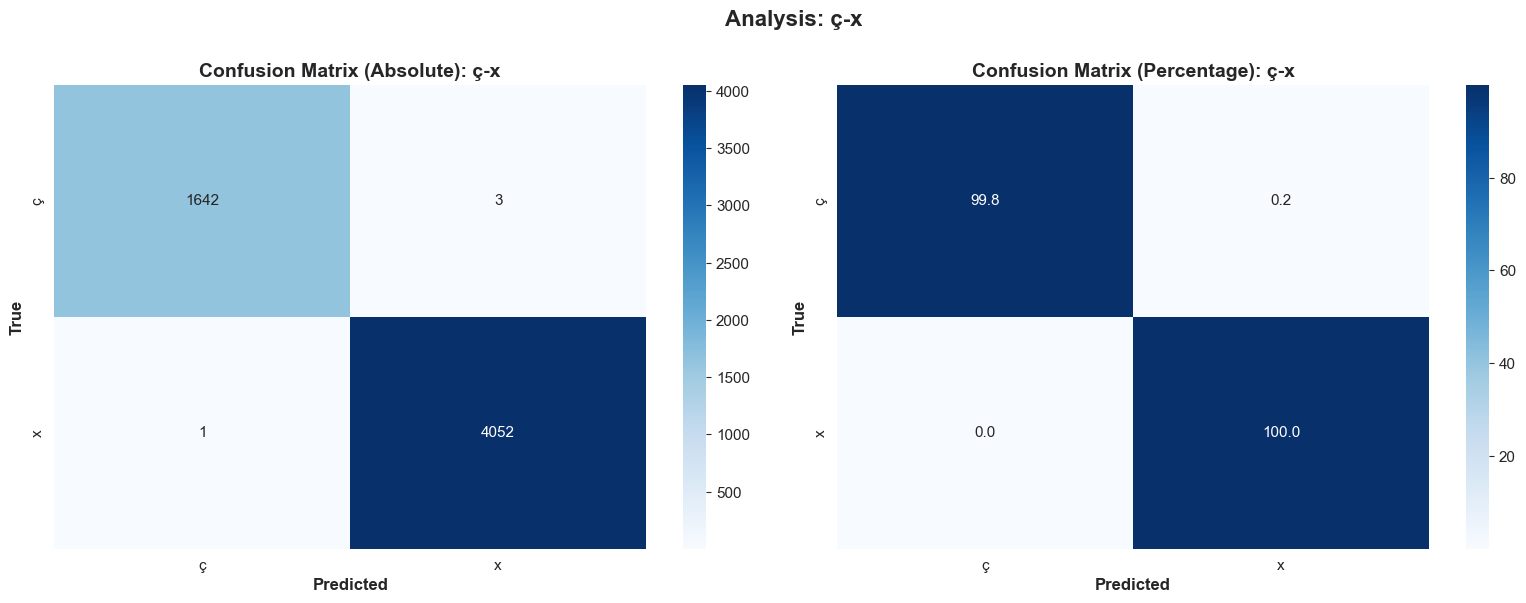


Classification Report:
              precision    recall  f1-score   support

           ç     0.9994    0.9982    0.9988      1645
           x     0.9993    0.9998    0.9995      4053

    accuracy                         0.9993      5698
   macro avg     0.9993    0.9990    0.9991      5698
weighted avg     0.9993    0.9993    0.9993      5698


Total misclassifications: 4

Misclassifications by true class:
  ç: 1/4053 (0.02%)
  x: 3/1645 (0.18%)

Probability Statistics:
Correct predictions:
  Mean: 0.9428, Median: 0.9473, Std: 0.0247
Incorrect predictions:
  Mean: 0.8470, Median: 0.8400, Std: 0.0486

DETAILED MISCLASSIFICATION ANALYSIS: ç-x

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      13429          ç               x  0.919775
      18251          x               ç  0.857133
      13862          x               ç  0.822928
       3699          x               ç  0.787971

Misclassified phonemes with

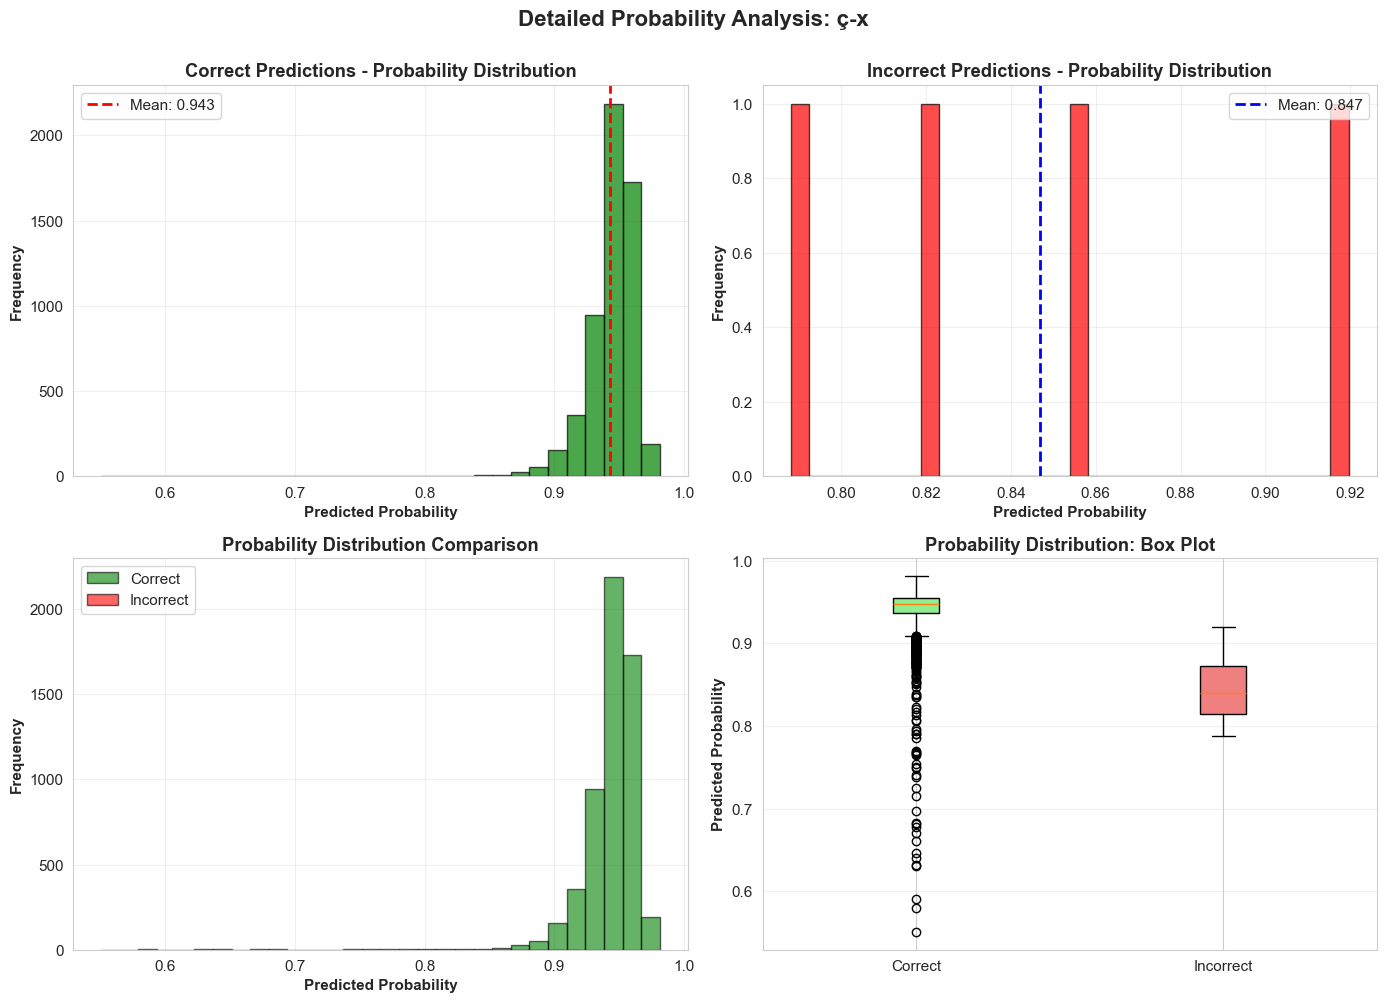




Analyzing: ç-ʃ

Error analyzing ç-ʃ: [Errno 2] No such file or directory: '/Volumes/SSanDisk/SpeechRec-German/artifacts/ç-ʃ_dl_models_with_context_v2/improved_models/hybrid_cnn_mlp_v4_3_enhanced/test_predictions_with_probs.csv'



Analyzing: ŋ-n

Loaded 20500 predictions
Correct: 19406, Incorrect: 1094

Model Performance:
  Accuracy: 0.9466
  F1-score: 0.9517
  Precision: 0.9628
  Recall: 0.9466
  ROC-AUC: 0.9789


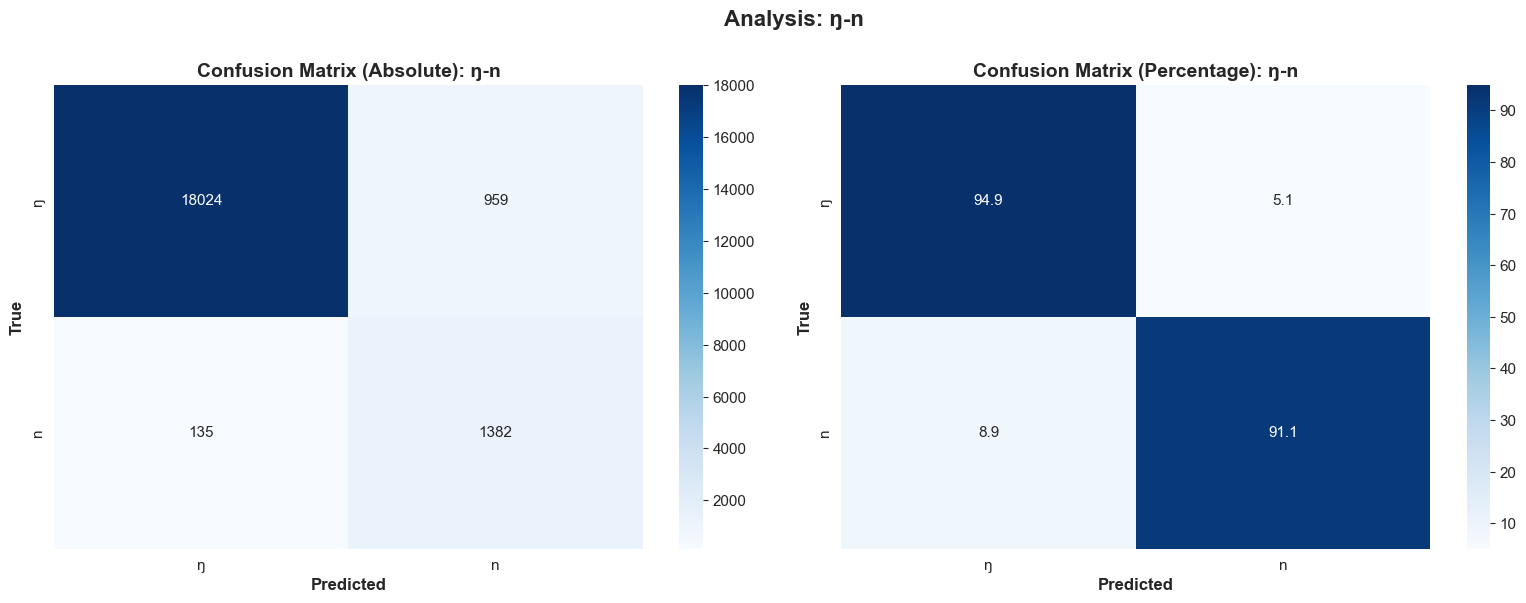


Classification Report:
              precision    recall  f1-score   support

           ŋ     0.9926    0.9495    0.9705     18983
           n     0.5903    0.9110    0.7164      1517

    accuracy                         0.9466     20500
   macro avg     0.7915    0.9302    0.8435     20500
weighted avg     0.9628    0.9466    0.9517     20500


Total misclassifications: 1094

Misclassifications by true class:
  ŋ: 135/1517 (8.90%)
  n: 959/18983 (5.05%)

Probability Statistics:
Correct predictions:
  Mean: 0.9032, Median: 0.9337, Std: 0.0952
Incorrect predictions:
  Mean: 0.6818, Median: 0.6756, Std: 0.1098

DETAILED MISCLASSIFICATION ANALYSIS: ŋ-n

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
     110506          ŋ               n  0.986838
      56700          ŋ               n  0.979760
      72047          ŋ               n  0.965294
      33531          ŋ               n  0.950508
      35275         

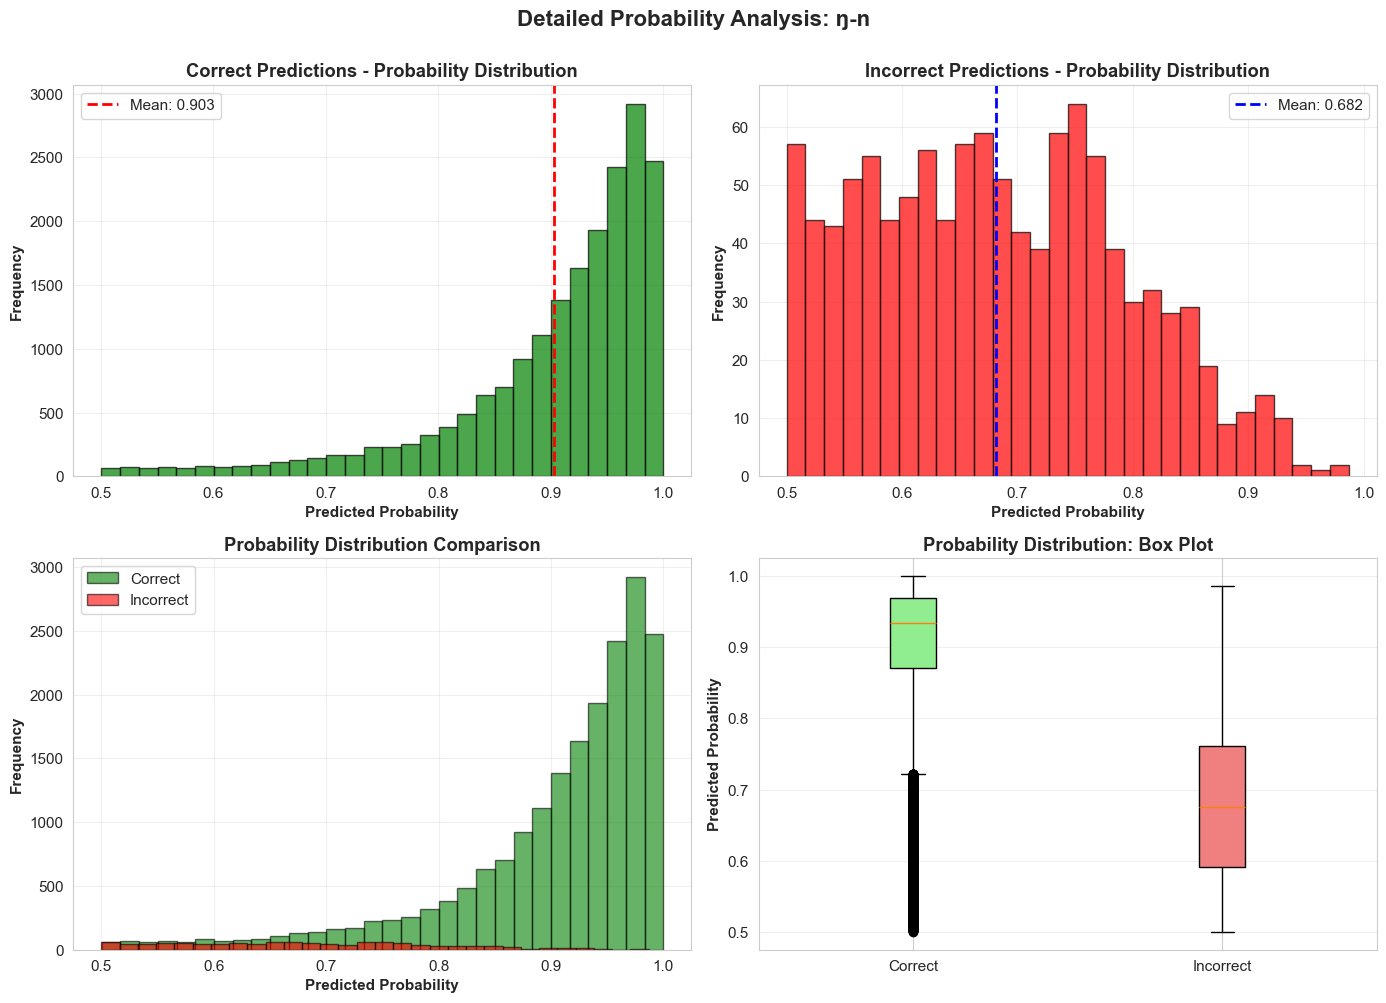




Analyzing: ə-ɛ

Loaded 20204 predictions
Correct: 18768, Incorrect: 1436

Model Performance:
  Accuracy: 0.9289
  F1-score: 0.9296
  Precision: 0.9314
  Recall: 0.9289
  ROC-AUC: 0.9777


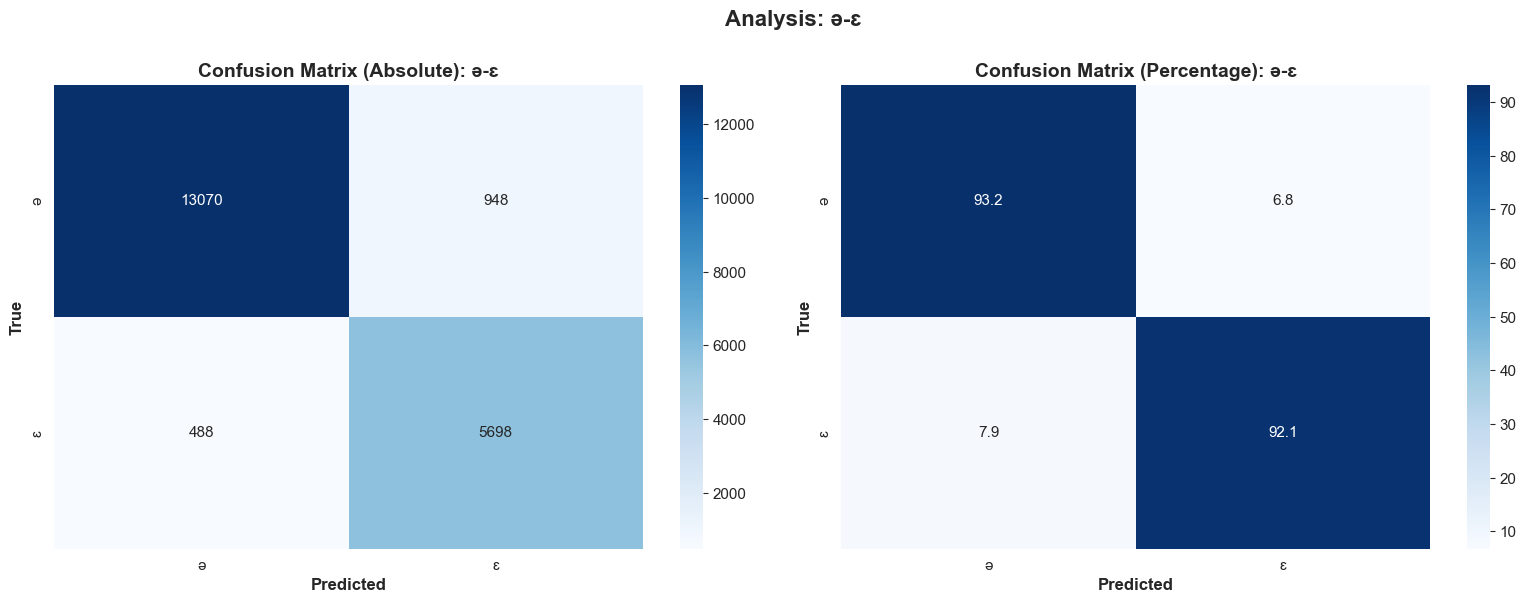


Classification Report:
              precision    recall  f1-score   support

           ə     0.9640    0.9324    0.9479     14018
           ɛ     0.8574    0.9211    0.8881      6186

    accuracy                         0.9289     20204
   macro avg     0.9107    0.9267    0.9180     20204
weighted avg     0.9314    0.9289    0.9296     20204


Total misclassifications: 1436

Misclassifications by true class:
  ə: 948/14018 (6.76%)
  ɛ: 488/6186 (7.89%)

Probability Statistics:
Correct predictions:
  Mean: 0.7736, Median: 0.7887, Std: 0.1074
Incorrect predictions:
  Mean: 0.6167, Median: 0.5898, Std: 0.0966

DETAILED MISCLASSIFICATION ANALYSIS: ə-ɛ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      61838          ə               ɛ  0.939197
     101690          ə               ɛ  0.924571
      24642          ə               ɛ  0.918591
      24175          ə               ɛ  0.916929
      93190         

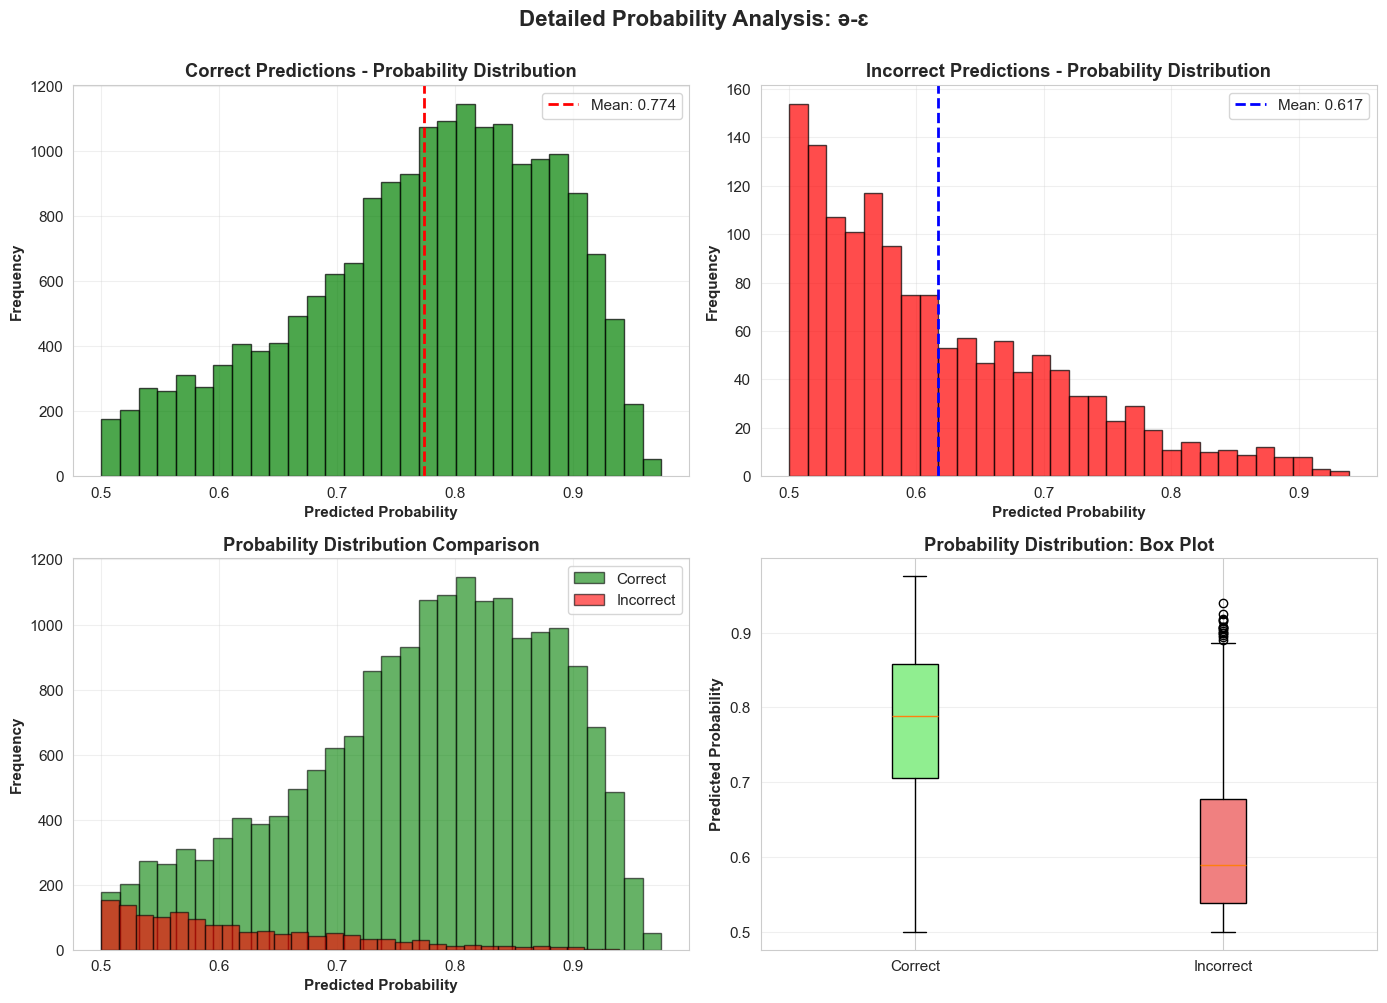




Analyzing: ʁ-ɐ

Loaded 15348 predictions
Correct: 13321, Incorrect: 2027

Model Performance:
  Accuracy: 0.8679
  F1-score: 0.8677
  Precision: 0.8702
  Recall: 0.8679
  ROC-AUC: 0.9439


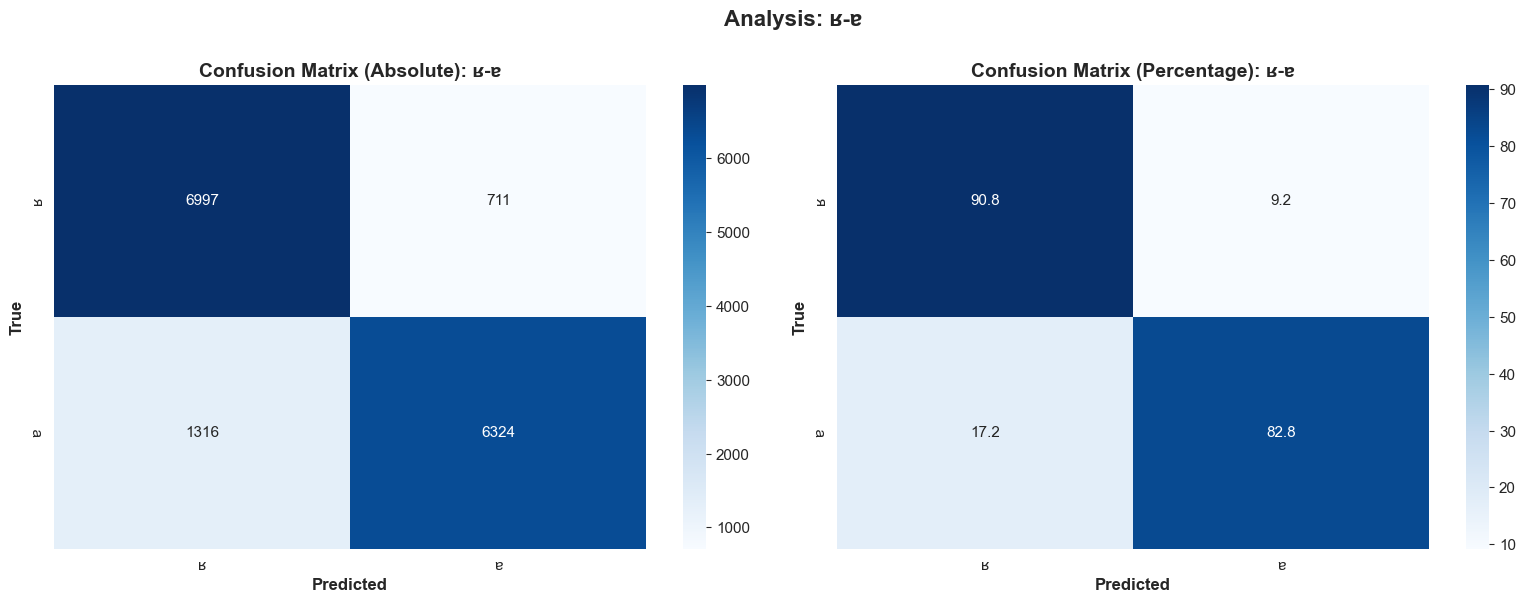


Classification Report:
              precision    recall  f1-score   support

           ʁ     0.8417    0.9078    0.8735      7708
           ɐ     0.8989    0.8277    0.8619      7640

    accuracy                         0.8679     15348
   macro avg     0.8703    0.8678    0.8677     15348
weighted avg     0.8702    0.8679    0.8677     15348


Total misclassifications: 2027

Misclassifications by true class:
  ʁ: 1316/7640 (17.23%)
  ɐ: 711/7708 (9.22%)

Probability Statistics:
Correct predictions:
  Mean: 0.7449, Median: 0.7407, Std: 0.1418
Incorrect predictions:
  Mean: 0.5778, Median: 0.5597, Std: 0.0673

DETAILED MISCLASSIFICATION ANALYSIS: ʁ-ɐ

Misclassified phonemes with highest confidence (most confident errors):
 phoneme_id true_class predicted_class  max_prob
      53907          ɐ               ʁ  0.918480
       4837          ɐ               ʁ  0.913030
      46491          ɐ               ʁ  0.905308
      86073          ɐ               ʁ  0.887828
      12708        

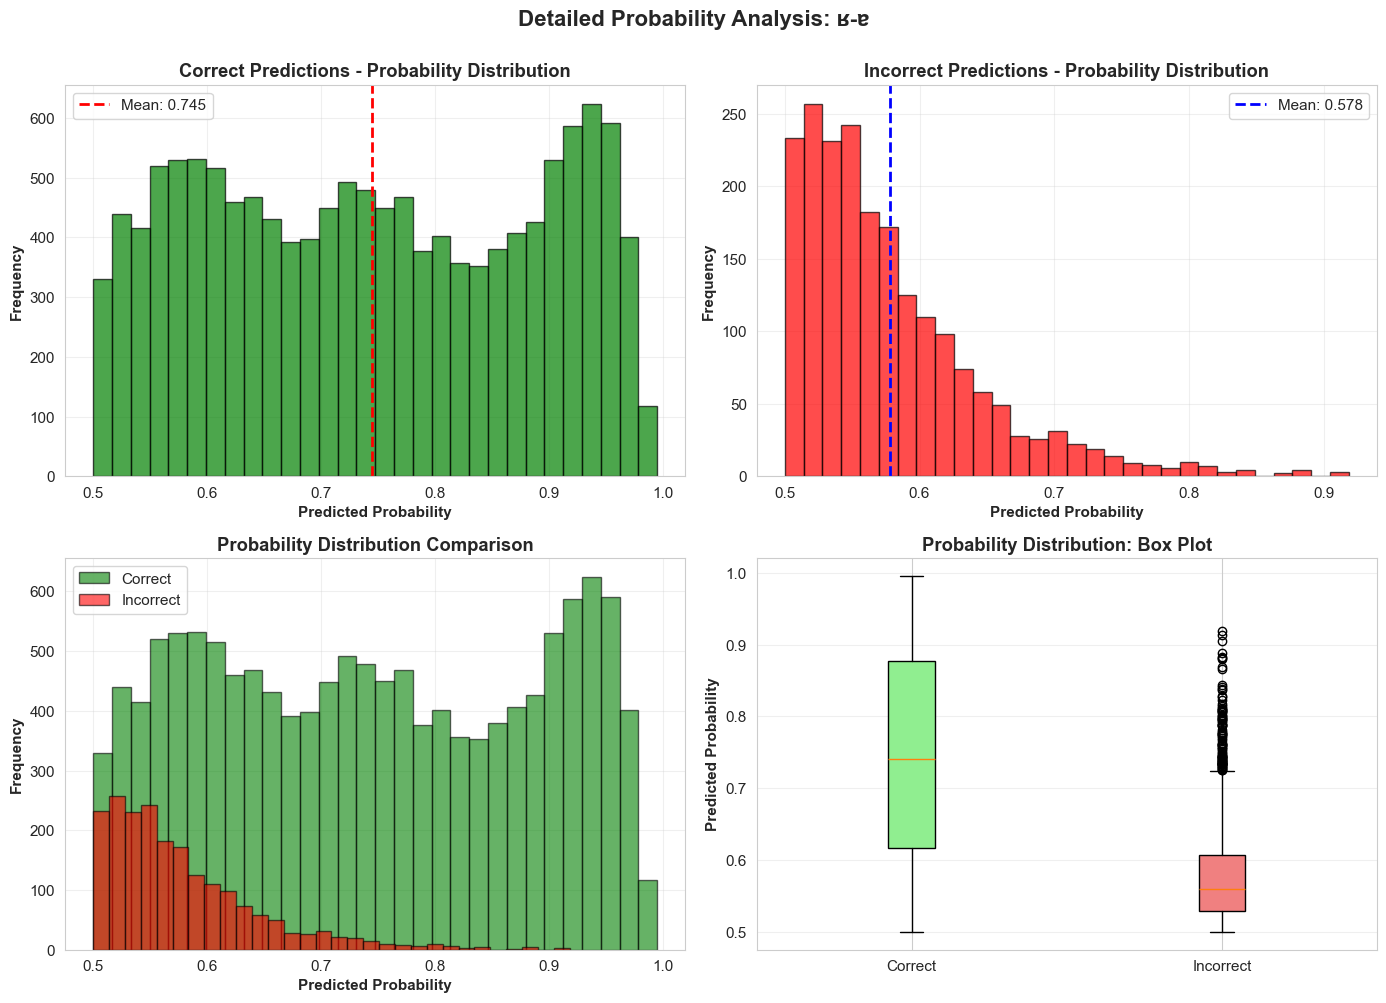

In [19]:
# Store results for all pairs
all_results = {}

# Analyze each pair
for pair_key, config in PAIRS_CONFIG.items():
    result = analyze_phoneme_pair(pair_key, config, show_plots=True)
    if result is not None:
        all_results[pair_key] = result
    print("\n" + "="*70 + "\n")

## Part 3: Summary Comparison Across All Pairs

SUMMARY: Performance Across All 22 Phoneme Pairs
                   Pair  Accuracy  F1-Score  Precision   Recall  ROC-AUC  Total Predictions  Correct  Incorrect  Error Rate
                    ç-x  0.999298  0.999298   0.999298 0.999298 0.999982               5698     5694          4    0.000702
                    x-k  0.996975  0.996975   0.996976 0.996975 0.999943               3967     3955         12    0.003025
                    s-ʃ  0.992293  0.992289   0.992287 0.992293 0.996802              10770    10687         83    0.007707
                 aʊ̯-aː  0.991265  0.991266   0.991267 0.991265 0.999389               5953     5901         52    0.008735
                    a-ɛ  0.976350  0.976365   0.976435 0.976350 0.996311              14292    13954        338    0.023650
b-p (Bilabial Plosives)  0.957912  0.958066   0.958354 0.957912 0.988162               5536     5303        233    0.042088
                   kʰ-g  0.952234  0.952479   0.953211 0.952234 0.988240           

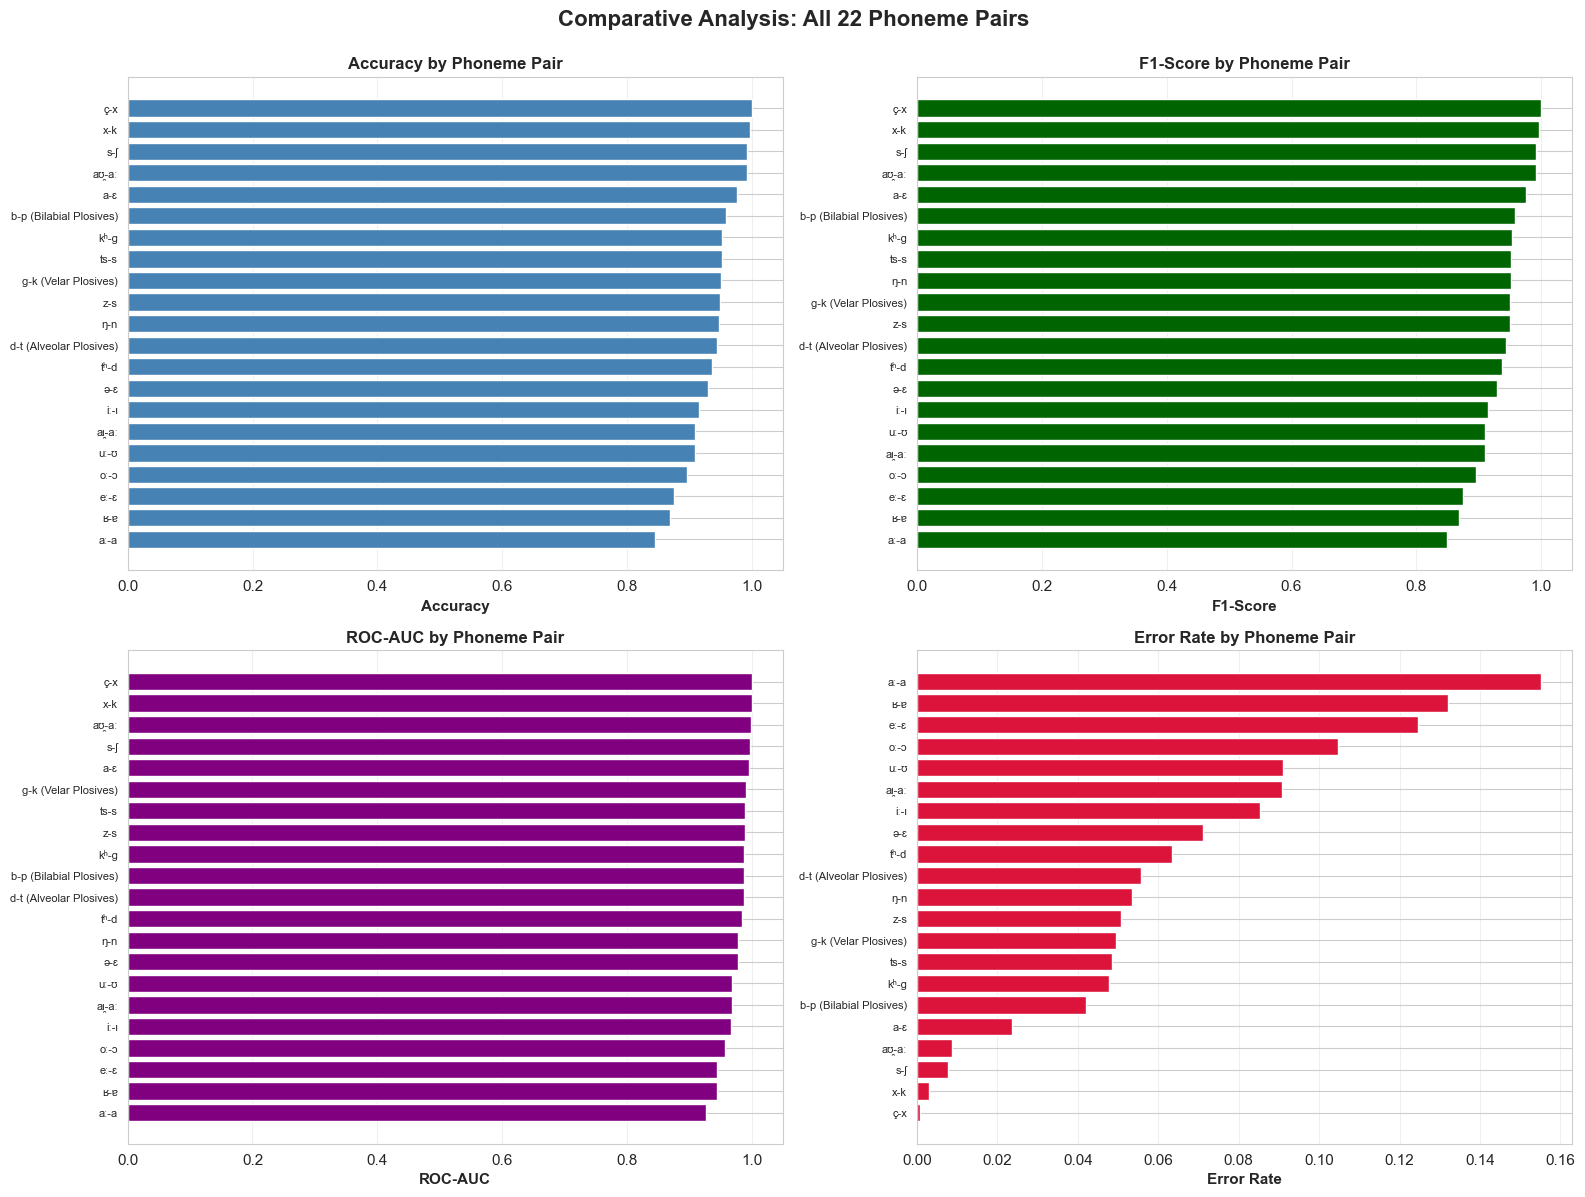


STATISTICS:
Mean Accuracy: 0.9376 ± 0.0432
Mean F1-Score: 0.9383 ± 0.0428
Mean ROC-AUC: 0.9783 ± 0.0206
Mean Error Rate: 0.0624 ± 0.0432

Best Performing Pair: ç-x (Accuracy: 0.9993)
Worst Performing Pair: aː-a (Accuracy: 0.8449)


In [20]:
# Create summary dataframe
summary_data = []
for pair_key, result in all_results.items():
    summary_data.append({
        'Pair': result['config']['name'],
        'Accuracy': result['metrics']['accuracy'],
        'F1-Score': result['metrics']['f1'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'ROC-AUC': result['metrics']['roc_auc'],
        'Total Predictions': len(result['predictions_df']),
        'Correct': result['predictions_df']['is_correct'].sum(),
        'Incorrect': (~result['predictions_df']['is_correct'].astype(bool)).sum(),
        'Error Rate': 1 - result['metrics']['accuracy']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy', ascending=False)

print("="*70)
print("SUMMARY: Performance Across All 22 Phoneme Pairs")
print("="*70)
print(summary_df.to_string(index=False))

# Visualize summary
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
ax1 = axes[0, 0]
summary_df_sorted = summary_df.sort_values('Accuracy', ascending=True)
ax1.barh(range(len(summary_df_sorted)), summary_df_sorted['Accuracy'], color='steelblue')
ax1.set_yticks(range(len(summary_df_sorted)))
ax1.set_yticklabels(summary_df_sorted['Pair'], fontsize=8)
ax1.set_xlabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy by Phoneme Pair', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# F1-Score comparison
ax2 = axes[0, 1]
summary_df_sorted_f1 = summary_df.sort_values('F1-Score', ascending=True)
ax2.barh(range(len(summary_df_sorted_f1)), summary_df_sorted_f1['F1-Score'], color='darkgreen')
ax2.set_yticks(range(len(summary_df_sorted_f1)))
ax2.set_yticklabels(summary_df_sorted_f1['Pair'], fontsize=8)
ax2.set_xlabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score by Phoneme Pair', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# ROC-AUC comparison
ax3 = axes[1, 0]
summary_df_sorted_auc = summary_df.sort_values('ROC-AUC', ascending=True)
ax3.barh(range(len(summary_df_sorted_auc)), summary_df_sorted_auc['ROC-AUC'], color='purple')
ax3.set_yticks(range(len(summary_df_sorted_auc)))
ax3.set_yticklabels(summary_df_sorted_auc['Pair'], fontsize=8)
ax3.set_xlabel('ROC-AUC', fontweight='bold')
ax3.set_title('ROC-AUC by Phoneme Pair', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='x')

# Error Rate comparison
ax4 = axes[1, 1]
summary_df_sorted_err = summary_df.sort_values('Error Rate', ascending=True)
ax4.barh(range(len(summary_df_sorted_err)), summary_df_sorted_err['Error Rate'], color='crimson')
ax4.set_yticks(range(len(summary_df_sorted_err)))
ax4.set_yticklabels(summary_df_sorted_err['Pair'], fontsize=8)
ax4.set_xlabel('Error Rate', fontweight='bold')
ax4.set_title('Error Rate by Phoneme Pair', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle('Comparative Analysis: All 22 Phoneme Pairs', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*70)
print("STATISTICS:")
print("="*70)
print(f"Mean Accuracy: {summary_df['Accuracy'].mean():.4f} ± {summary_df['Accuracy'].std():.4f}")
print(f"Mean F1-Score: {summary_df['F1-Score'].mean():.4f} ± {summary_df['F1-Score'].std():.4f}")
print(f"Mean ROC-AUC: {summary_df['ROC-AUC'].mean():.4f} ± {summary_df['ROC-AUC'].std():.4f}")
print(f"Mean Error Rate: {summary_df['Error Rate'].mean():.4f} ± {summary_df['Error Rate'].std():.4f}")
print(f"\nBest Performing Pair: {summary_df.iloc[0]['Pair']} (Accuracy: {summary_df.iloc[0]['Accuracy']:.4f})")
print(f"Worst Performing Pair: {summary_df.iloc[-1]['Pair']} (Accuracy: {summary_df.iloc[-1]['Accuracy']:.4f})")

## Part 4: Probability Distribution Comparison

Compare probability distributions across all pairs.

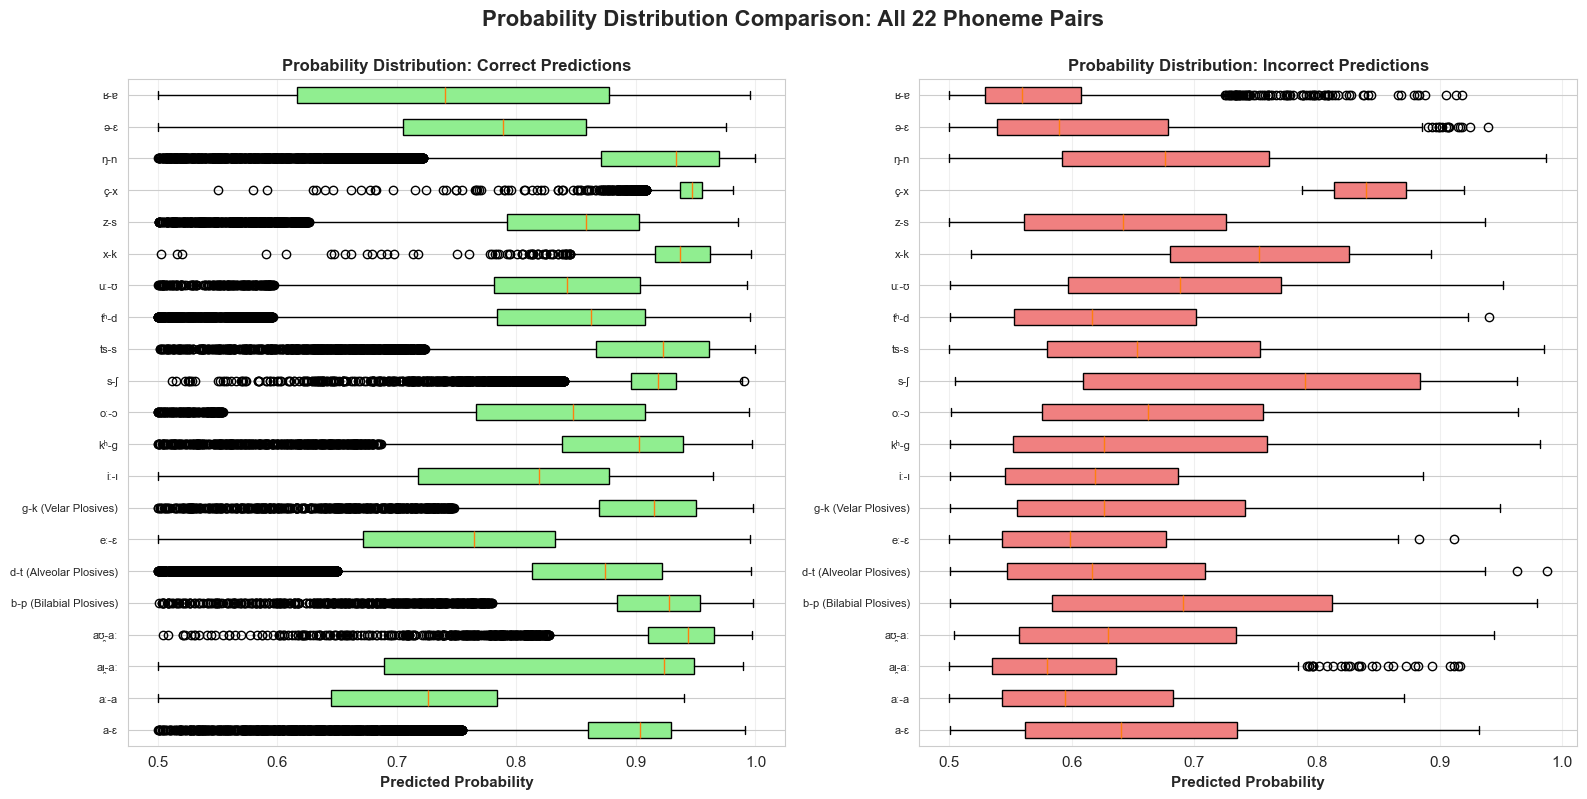


PROBABILITY STATISTICS SUMMARY:
                   Pair  Correct Mean  Correct Std  Incorrect Mean  Incorrect Std  Difference
                 aʊ̯-aː      0.926814     0.061288        0.649685       0.107138    0.277130
   g-k (Velar Plosives)      0.889023     0.095044        0.655832       0.118847    0.233192
                   ts-s      0.896271     0.092395        0.670320       0.112077    0.225951
                 aɪ̯-aː      0.820889     0.148125        0.595760       0.078537    0.225129
                    a-ɛ      0.879453     0.080377        0.657787       0.111503    0.221666
                    ŋ-n      0.903187     0.095242        0.681754       0.109839    0.221433
d-t (Alveolar Plosives)      0.849932     0.101889        0.638716       0.106240    0.211216
                   kʰ-g      0.869217     0.105389        0.662195       0.129460    0.207022
                    x-k      0.935227     0.037318        0.731366       0.127699    0.203860
b-p (Bilabial Plosives)    

In [22]:
# Box plot comparison of probabilities
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Correct predictions
ax1 = axes[0]
correct_data = [result['correct_probs'] for result in all_results.values()]
pair_names = [result['config']['name'] for result in all_results.values()]
bp1 = ax1.boxplot(correct_data, labels=pair_names, patch_artist=True, vert=False)
for patch in bp1['boxes']:
    patch.set_facecolor('lightgreen')
ax1.set_xlabel('Predicted Probability', fontweight='bold')
ax1.set_title('Probability Distribution: Correct Predictions', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')
plt.setp(ax1.get_yticklabels(), fontsize=8)

# Incorrect predictions
ax2 = axes[1]
incorrect_data = [result['incorrect_probs'] for result in all_results.values()]
bp2 = ax2.boxplot(incorrect_data, labels=pair_names, patch_artist=True, vert=False)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
ax2.set_xlabel('Predicted Probability', fontweight='bold')
ax2.set_title('Probability Distribution: Incorrect Predictions', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
plt.setp(ax2.get_yticklabels(), fontsize=8)

plt.suptitle('Probability Distribution Comparison: All 22 Phoneme Pairs', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Summary statistics
prob_summary = []
for pair_key, result in all_results.items():
    prob_summary.append({
        'Pair': result['config']['name'],
        'Correct Mean': result['correct_probs'].mean(),
        'Correct Std': result['correct_probs'].std(),
        'Incorrect Mean': result['incorrect_probs'].mean(),
        'Incorrect Std': result['incorrect_probs'].std(),
        'Difference': result['correct_probs'].mean() - result['incorrect_probs'].mean()
    })

prob_summary_df = pd.DataFrame(prob_summary)
prob_summary_df = prob_summary_df.sort_values('Difference', ascending=False)

print("\n" + "="*70)
print("PROBABILITY STATISTICS SUMMARY:")
print("="*70)
print(prob_summary_df.to_string(index=False))

## Part 5: Export Summary Results

Export the summary statistics to CSV for further analysis.

In [24]:
# Export summary to CSV
output_dir = PROJECT_ROOT / 'notebooks' / 'results'
output_dir.mkdir(exist_ok=True)

summary_df.to_csv(output_dir / 'all_22_pairs_summary.csv', index=False)
prob_summary_df.to_csv(output_dir / 'all_22_pairs_probability_summary.csv', index=False)

print(f"Summary results exported to:")
print(f"  - {output_dir / 'all_22_pairs_summary.csv'}")
print(f"  - {output_dir / 'all_22_pairs_probability_summary.csv'}")
print("\nAnalysis complete!")

Summary results exported to:
  - /Volumes/SSanDisk/SpeechRec-German/notebooks/results/all_22_pairs_summary.csv
  - /Volumes/SSanDisk/SpeechRec-German/notebooks/results/all_22_pairs_probability_summary.csv

Analysis complete!
